# Preliminary

In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

from datetime import datetime

import requests
import bs4 as bs

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from math import sqrt

import warnings
warnings.filterwarnings('ignore')


In [13]:
# get tickers in SPY
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)
tickers = [s.replace('\n', '') for s in tickers]
print('Get tickers list done')

# get industry
SPY = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sector = SPY[['Symbol','GICS Sector']]
print('Get industry done')

#get tickers' weight
marketCap = {'Symbol':[],'Cap':[]}
for ticker in tickers:
    try:
        ticket_cap = yf.Ticker(ticker).fast_info['marketCap']
        marketCap['Symbol'].append(ticker)
        marketCap['Cap'].append(ticket_cap)
    except:
        continue
marketCap = pd.DataFrame(marketCap)
marketCap['Weight'] = marketCap['Cap']/marketCap['Cap'].sum()
print('Get tickers weight done')

#merge all
ticketsInfo = pd.merge(marketCap, sector, on='Symbol')
print('Complete')

Get tickers list done
Get industry done
Get tickers weight done
Complete


In [14]:
ticketsInfo['GICS Sector'].unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Utilities', 'Financials', 'Materials', 'Consumer Discretionary',
       'Real Estate', 'Communication Services', 'Consumer Staples',
       'Energy'], dtype=object)

In [15]:
ticketsInfo[ticketsInfo['GICS Sector']=='Information Technology'].sort_values(['Cap'],ascending=False).head(10)

Symbol           Cap    Weight             GICS Sector
318   MSFT  3.081259e+12  0.066920  Information Technology
39    AAPL  2.594239e+12  0.056343  Information Technology
348   NVDA  2.100875e+12  0.045628  Information Technology
74    AVGO  5.943977e+11  0.012909  Information Technology
357   ORCL  3.261657e+11  0.007084  Information Technology
409    CRM  2.690876e+11  0.005844  Information Technology
6      AMD  2.640765e+11  0.005735  Information Technology
5     ADBE  2.143575e+11  0.004656  Information Technology
4      ACN  1.977604e+11  0.004295  Information Technology
110   CSCO  1.935108e+11  0.004203  Information Technology

In [16]:
ticketsInfo[ticketsInfo['Symbol']=='AMZN']

Symbol           Cap    Weight             GICS Sector
22   AMZN  1.885801e+12  0.040957  Consumer Discretionary


# Descriptive Statistics

In [17]:
# Set up End and Start times for data grab
tech_list = ['AMZN', 'BABA', 'PDD', 'MPNGY', 'MELI']

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)
    

company_list = [AMZN, BABA, PDD, MPNGY, MELI]
company_name = ["Amazon", "Alibaba", "PDD", "Meituan", 'MercadoLibre']

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.tail(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Open         High          Low        Close    Adj Close  \
Date                                                                          
2024-04-04  1524.119995  1531.150024  1486.540039  1487.810059  1487.810059   
2024-04-05  1495.130005  1507.000000  1486.030029  1501.719971  1501.719971   
2024-04-08  1513.250000  1513.979980  1488.000000  1488.579956  1488.579956   
2024-04-09  1492.369995  1503.000000  1478.619995  1495.010010  1495.010010   
2024-04-10  1474.849976  1491.859985  1463.489990  1478.000000  1478.000000   
2024-04-11  1486.000000  1509.020020  1479.000000  1507.560059  1507.560059   
2024-04-12  1495.189941  1517.140015  1442.890015  1444.140015  1444.140015   
2024-04-15  1466.390015  1495.300049  1400.829956  1415.880005  1415.880005   
2024-04-16  1418.000000  1419.849976  1396.689941  1397.880005  1397.880005   
2024-04-17  1404.400024  1414.189941  1389.000000  1397.859985  1397.859985   

            Volume  company_name  
Date                              
2024-04-04  252000  MercadoLibre  
2024-04-05  291700  MercadoLibre  
2024-04-08  230600  MercadoLibre  
2024-04-09  255300  MercadoLibre  
2024-04-10  251600  MercadoLibre  
2024-04-11  286800  MercadoLibre  
2024-04-12  537400  MercadoLibre  
2024-04-15  627100  MercadoLibre  
2024-04-16  364700  MercadoLibre  
2024-04-17  448600  MercadoLibre

##  Stock Statistics

In [19]:
# Summary Stats
AMZN.describe()

Open        High         Low       Close   Adj Close  \
count  252.000000  252.000000  252.000000  252.000000  252.000000   
mean   142.369683  143.960754  140.894445  142.491191  142.491191   
std     21.576525   21.586071   21.516565   21.605528   21.605528   
min    101.470001  103.900002  101.150002  102.050003  102.050003   
25%    128.179996  129.722504  126.392502  128.195004  128.195004   
50%    138.739998  139.725006  137.050003  138.174995  138.174995   
75%    154.512497  155.869995  153.119995  154.659996  154.659996   
max    187.720001  189.770004  185.509995  189.050003  189.050003   

             Volume  
count  2.520000e+02  
mean   5.221375e+07  
std    1.951367e+07  
min    2.237840e+07  
25%    4.142802e+07  
50%    4.827710e+07  
75%    5.839938e+07  
max    1.529387e+08

In [20]:
BABA.describe()

Open        High         Low       Close   Adj Close  \
count  252.000000  252.000000  252.000000  252.000000  252.000000   
mean    81.849702   82.808520   80.992040   81.888293   81.114612   
std      8.143906    8.281591    7.891248    8.058762    7.626302   
min     67.199997   68.737999   66.629997   68.050003   68.050003   
25%     74.322502   75.015001   73.330002   73.969999   73.827501   
50%     82.755001   83.720001   82.146000   82.875000   81.775715   
75%     87.429998   88.480003   86.651247   87.542501   86.381304   
max     99.870003  102.500000   99.720001  102.160004  100.804916   

             Volume  
count  2.520000e+02  
mean   1.791555e+07  
std    8.519068e+06  
min    7.233900e+06  
25%    1.228920e+07  
50%    1.628865e+07  
75%    2.077962e+07  
max    6.300850e+07

In [21]:
PDD.describe()

Open        High         Low       Close   Adj Close  \
count  252.000000  252.000000  252.000000  252.000000  252.000000   
mean   103.601111  105.518016  101.845714  103.732182  103.732182   
std     27.362746   27.687512   27.030302   27.363668   27.363668   
min     59.799999   61.529999   59.669998   60.020000   60.020000   
25%     77.774998   79.744997   76.039997   78.024998   78.024998   
50%    103.634998  106.244999  102.709999  104.555000  104.555000   
75%    126.025000  128.010002  123.427500  125.404999  125.404999   
max    151.899994  152.990005  149.830002  151.330002  151.330002   

             Volume  
count  2.520000e+02  
mean   8.721140e+06  
std    5.062294e+06  
min    3.031200e+06  
25%    5.783075e+06  
50%    7.474350e+06  
75%    9.788050e+06  
max    4.561610e+07

In [22]:
MPNGY.describe()

Open        High         Low       Close   Adj Close  \
count  252.000000  252.000000  252.000000  252.000000  252.000000   
mean    27.694397   27.992528   27.414548   27.719516   27.719516   
std      5.906747    5.960145    5.858562    5.909024    5.909024   
min     16.030001   16.030001   15.700000   15.830000   15.830000   
25%     22.250000   22.585000   22.125000   22.540000   22.540000   
50%     28.839999   29.315000   28.570001   28.920000   28.920000   
75%     32.802500   33.242501   32.604999   32.802500   32.802500   
max     37.939999   38.189999   37.490002   38.189999   38.189999   

             Volume  
count  2.520000e+02  
mean   2.700385e+05  
std    2.718297e+05  
min    2.230000e+04  
25%    1.074000e+05  
50%    1.961500e+05  
75%    3.234500e+05  
max    2.486100e+06

In [23]:
MELI.describe()

Open         High          Low        Close    Adj Close  \
count   252.000000   252.000000   252.000000   252.000000   252.000000   
mean   1404.361071  1423.785557  1383.012742  1403.054445  1403.054445   
std     185.093544   185.061119   185.283749   185.822773   185.822773   
min    1087.150024  1109.489990  1063.020020  1087.150024  1087.150024   
25%    1242.402527  1257.992493  1218.059967  1240.237518  1240.237518   
50%    1349.380005  1380.230042  1331.565002  1350.970032  1350.970032   
75%    1560.809967  1581.467499  1546.324951  1563.265015  1563.265015   
max    1796.979980  1825.000000  1760.349976  1817.979980  1817.979980   

             Volume  
count  2.520000e+02  
mean   4.333857e+05  
std    2.089250e+05  
min    1.433000e+05  
25%    3.029000e+05  
50%    3.803000e+05  
75%    5.010750e+05  
max    1.858200e+06

## Closing Price

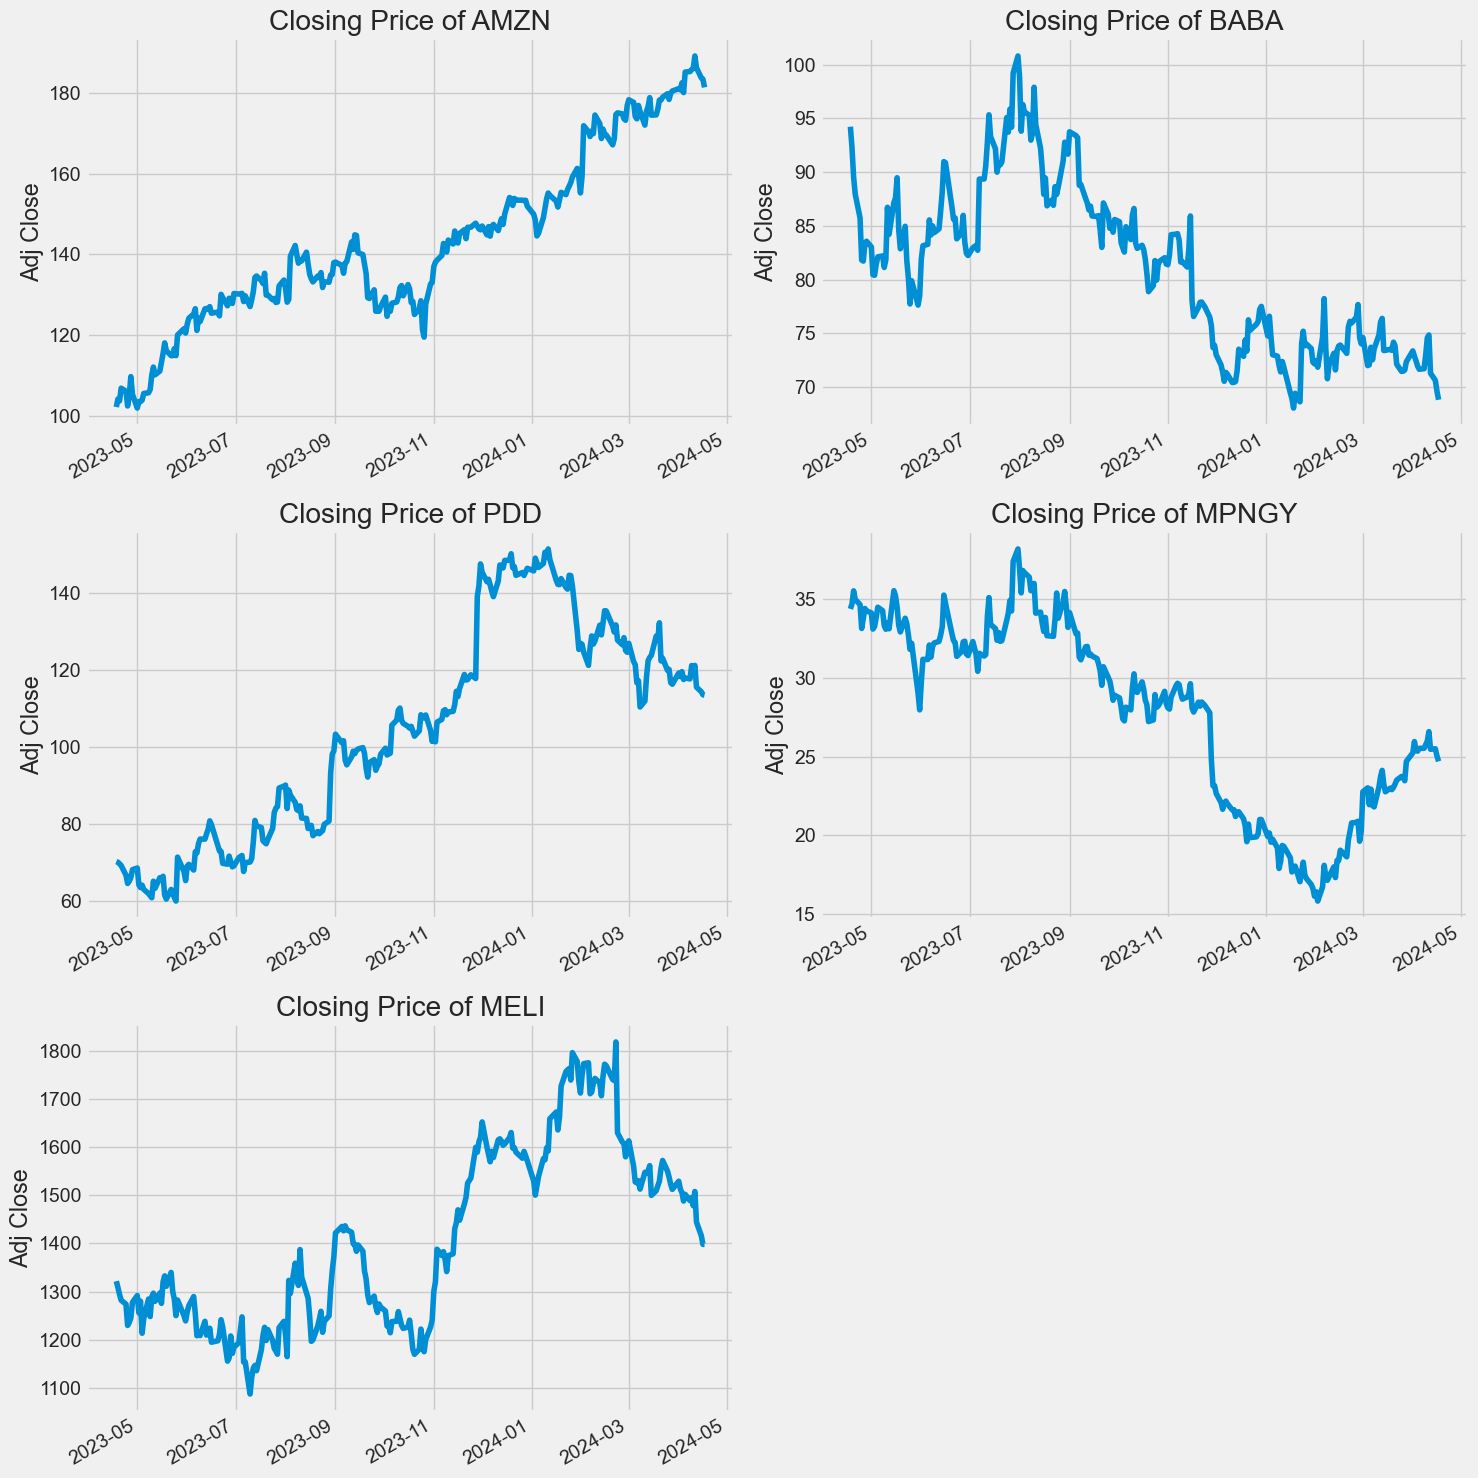

In [24]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 15))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(3, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

## Volume of Sales

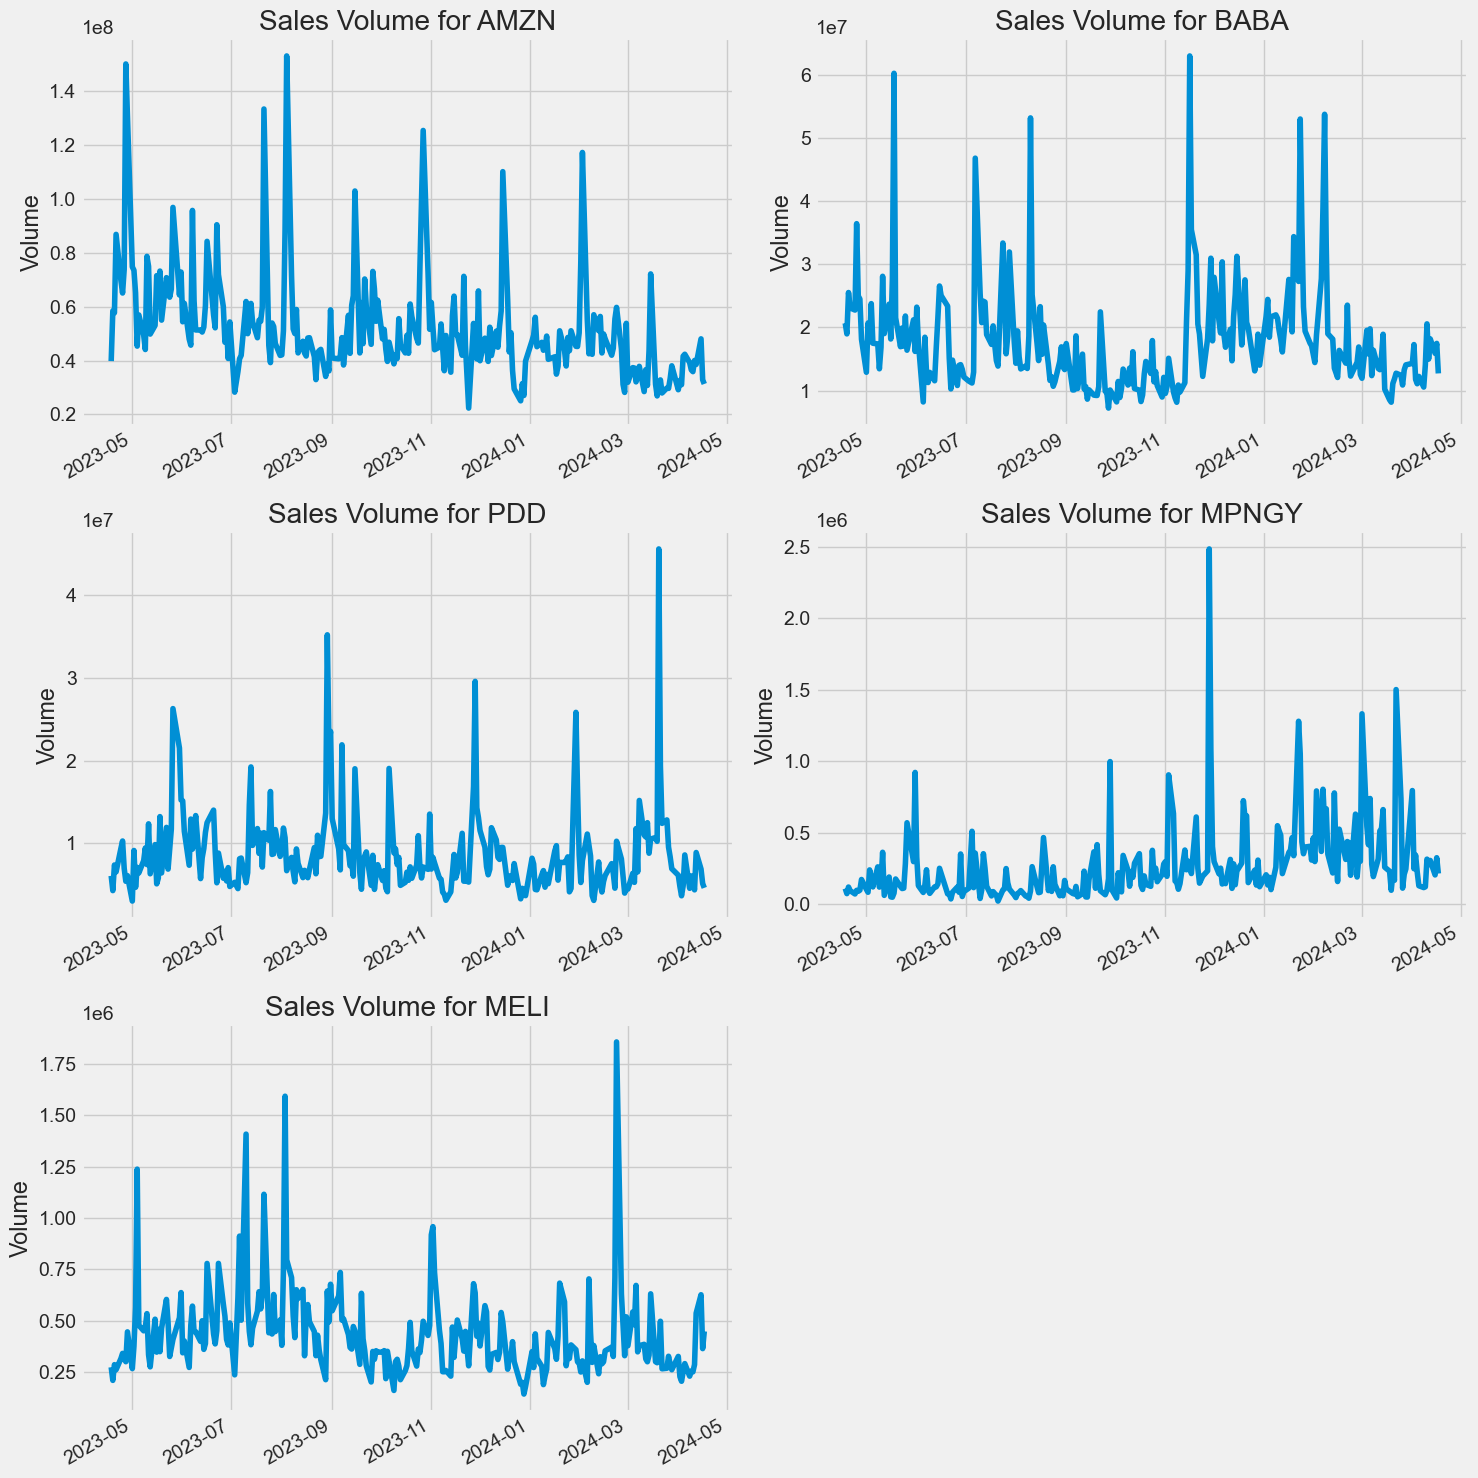

In [25]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(15, 15))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(3, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {tech_list[i - 1]}")
    
plt.tight_layout()

## Moving average

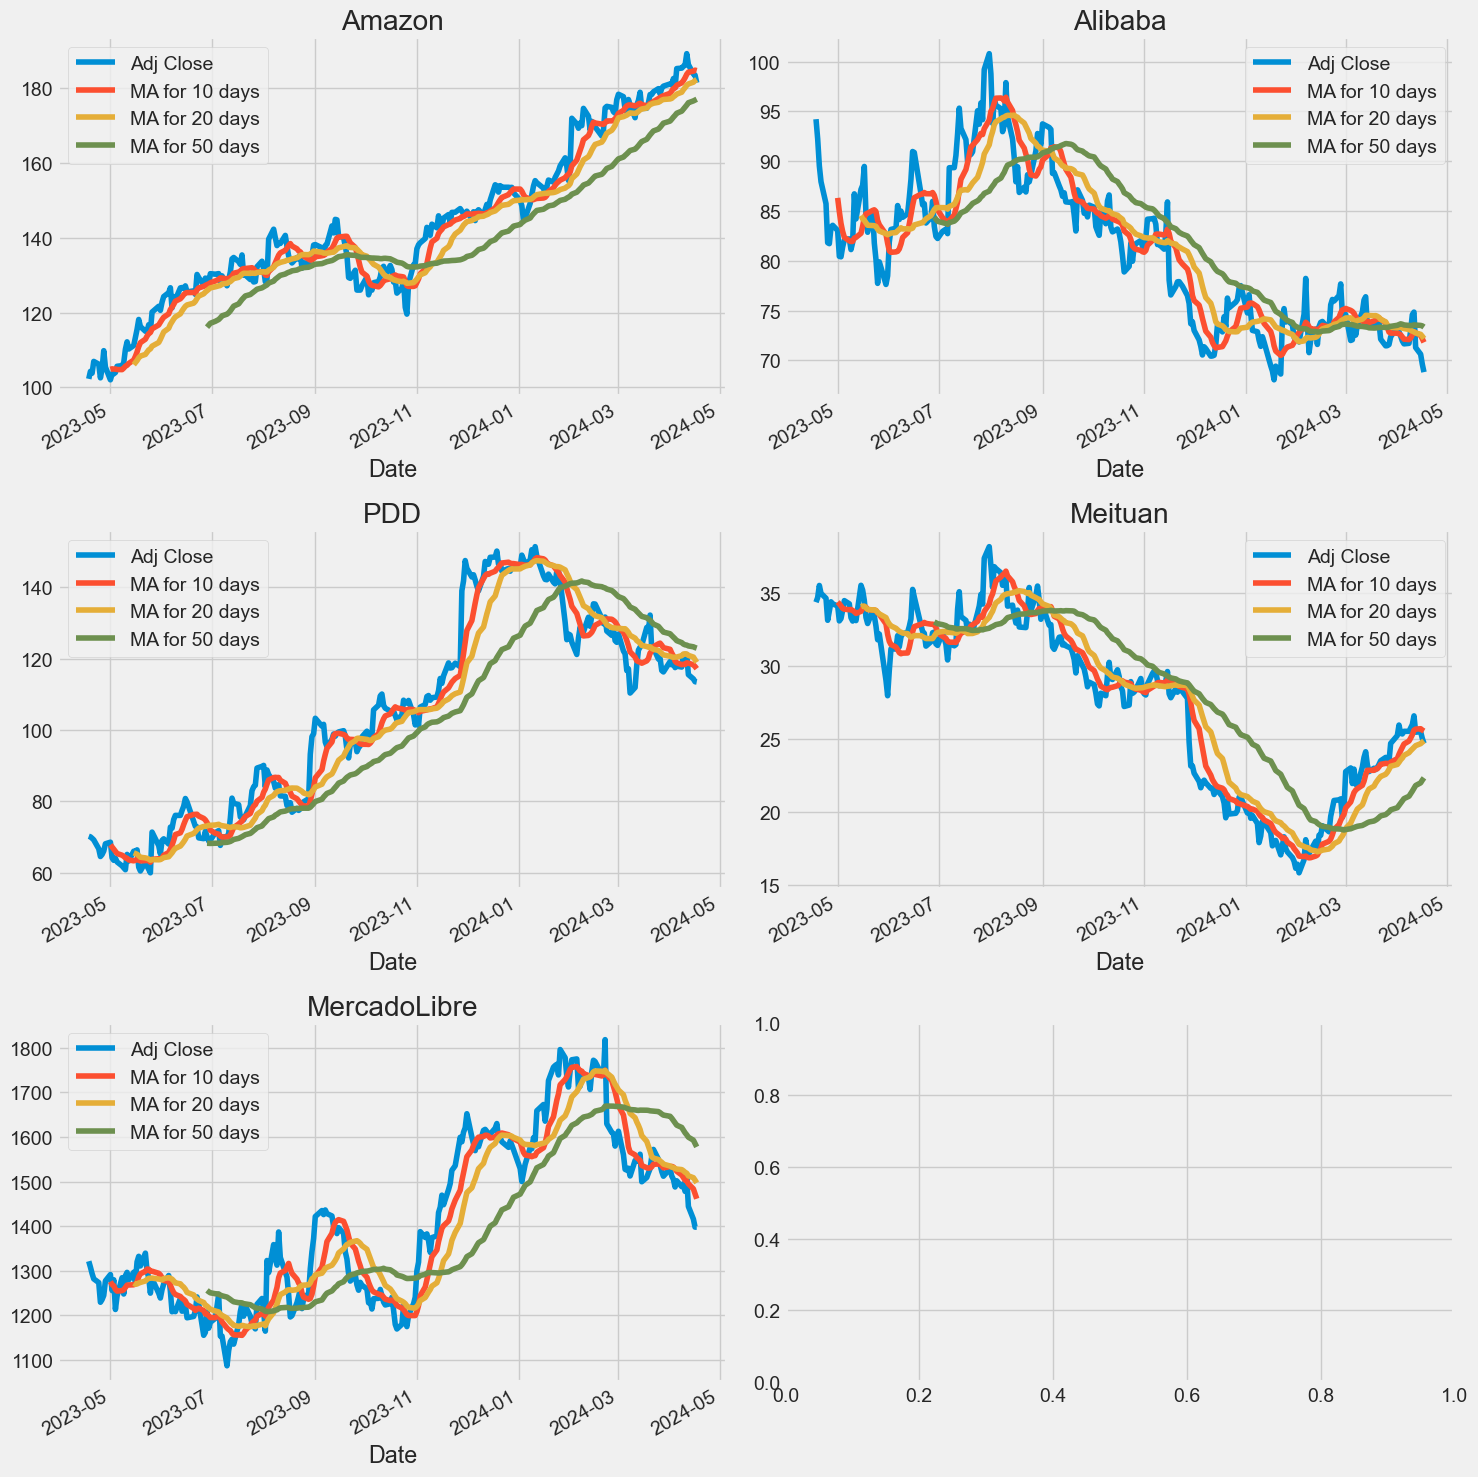

In [26]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()
        

fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(15)

AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('Amazon')

BABA[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('Alibaba')

PDD[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('PDD')

MPNGY[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('Meituan')

MELI[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[2,0])
axes[2,0].set_title('MercadoLibre')

fig.tight_layout()

## Daily return on average

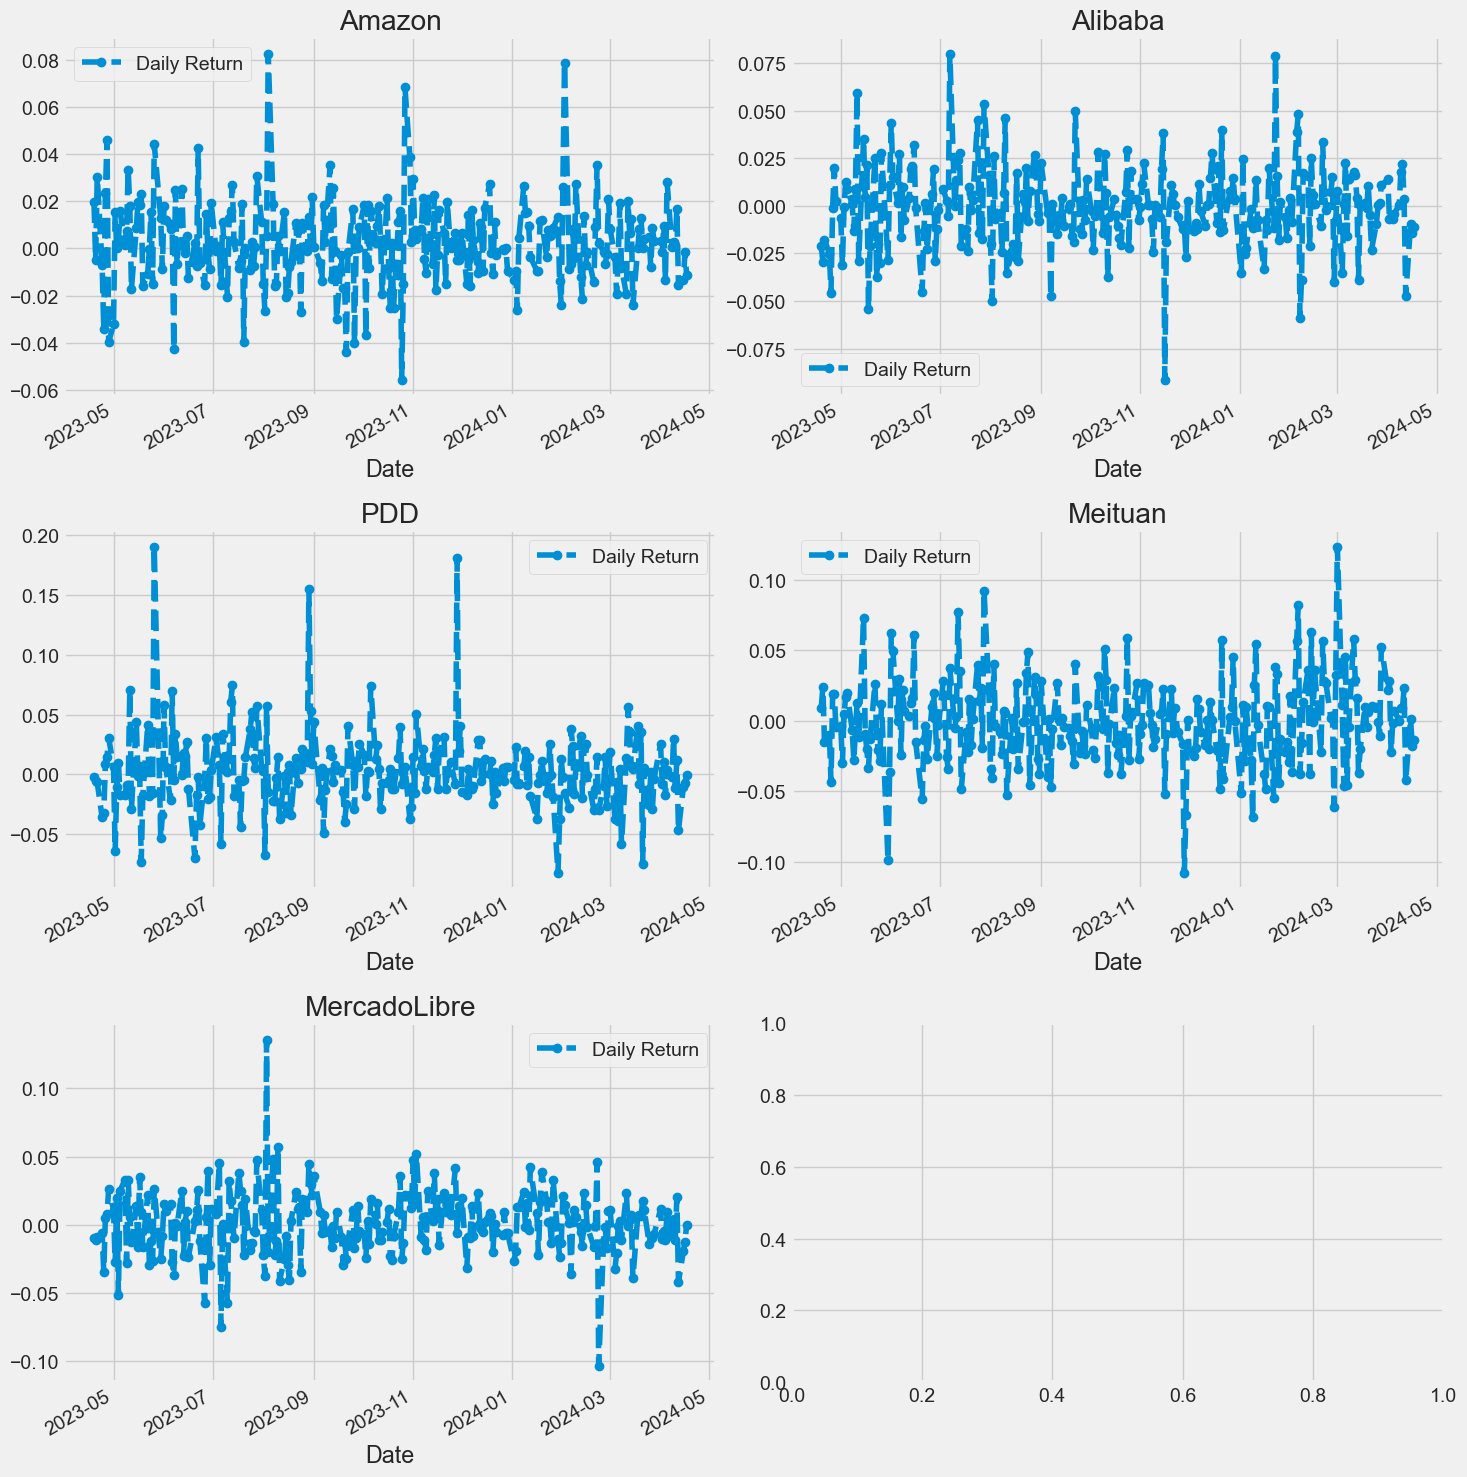

In [27]:
# We'll use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(15)

AMZN['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('Amazon')

BABA['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('Alibaba')

PDD['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('PDD')

MPNGY['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('Meituan')

MELI['Daily Return'].plot(ax=axes[2,0], legend=True, linestyle='--', marker='o')
axes[2,0].set_title('MercadoLibre')

fig.tight_layout()

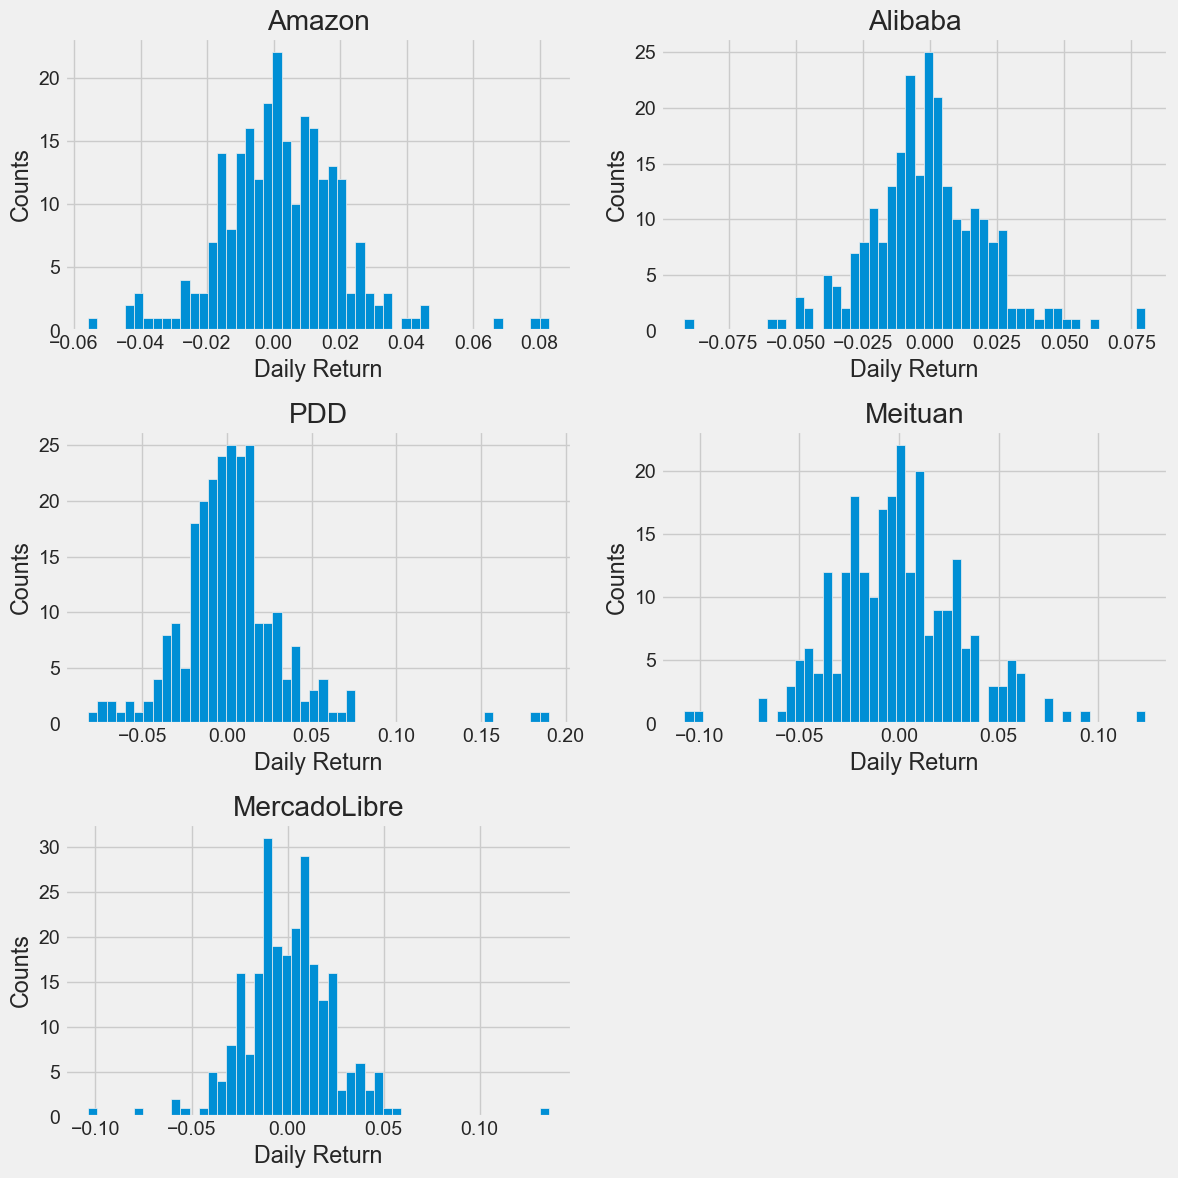

In [28]:
plt.figure(figsize=(12, 12))

for i, company in enumerate(company_list, 1):
    plt.subplot(3, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i - 1]}')
    
plt.tight_layout()

# Risk analysis

## Correlation between different stocks

In [29]:
# Grab all the closing prices for the tech stock list into one DataFrame

closing_df = pdr.get_data_yahoo(tech_list, start=start, end=end)['Adj Close']

# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()

[*********************100%%**********************]  5 of 5 completed


Ticker          AMZN      BABA      MELI     MPNGY       PDD
Date                                                        
2023-04-18       NaN       NaN       NaN       NaN       NaN
2023-04-19  0.019550 -0.020945 -0.009974  0.009308 -0.002420
2023-04-20 -0.004698 -0.029415 -0.011098  0.023919 -0.005707
2023-04-21  0.030344 -0.017743 -0.009159 -0.015198 -0.006601
2023-04-24 -0.007012 -0.025132 -0.006475 -0.009717 -0.035823

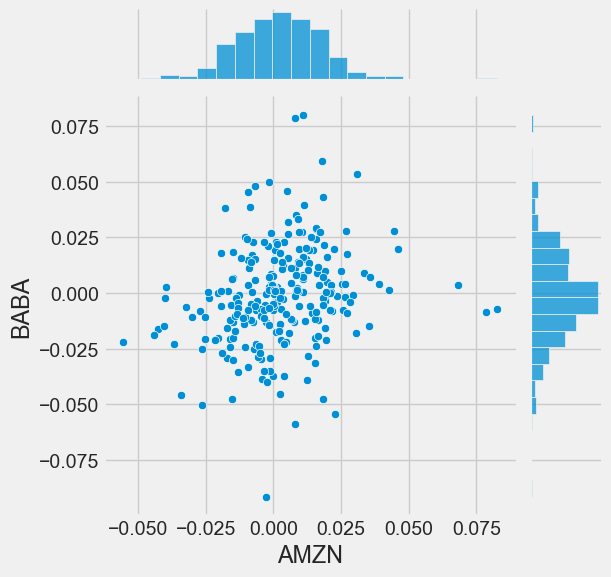

In [30]:
# We'll use joinplot to compare the daily returns of Amazon and Alibaba
sns.jointplot(x='AMZN', y='BABA', data=tech_rets, kind='scatter')

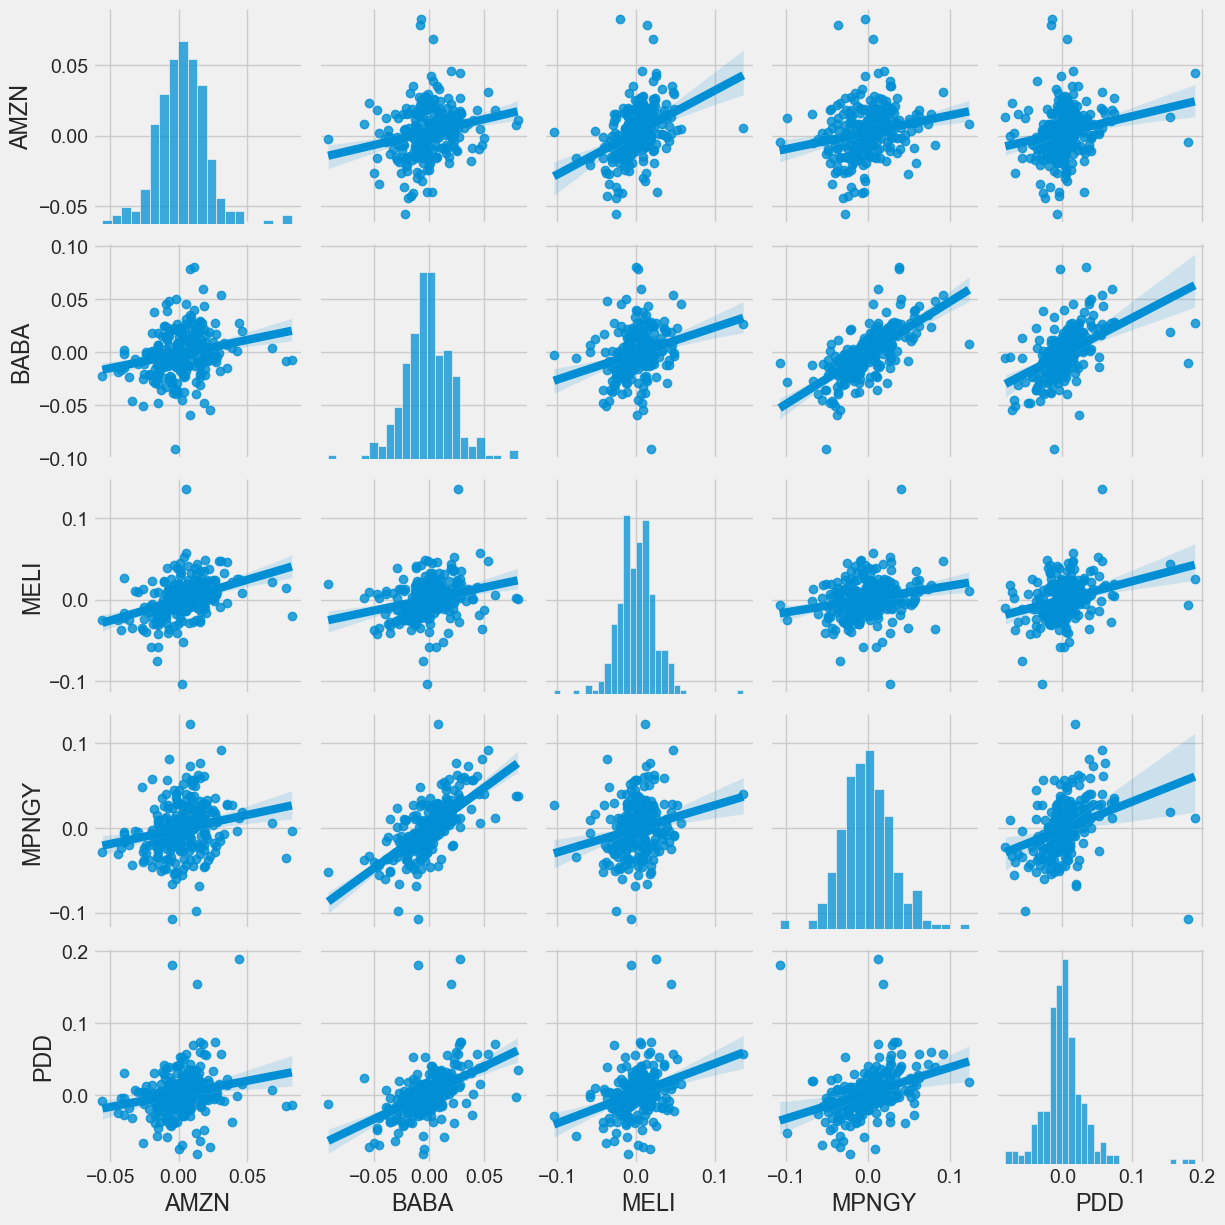

In [31]:
# We can simply call pairplot on our DataFrame for an automatic visual analysis of all the comparisons

sns.pairplot(tech_rets, kind='reg')

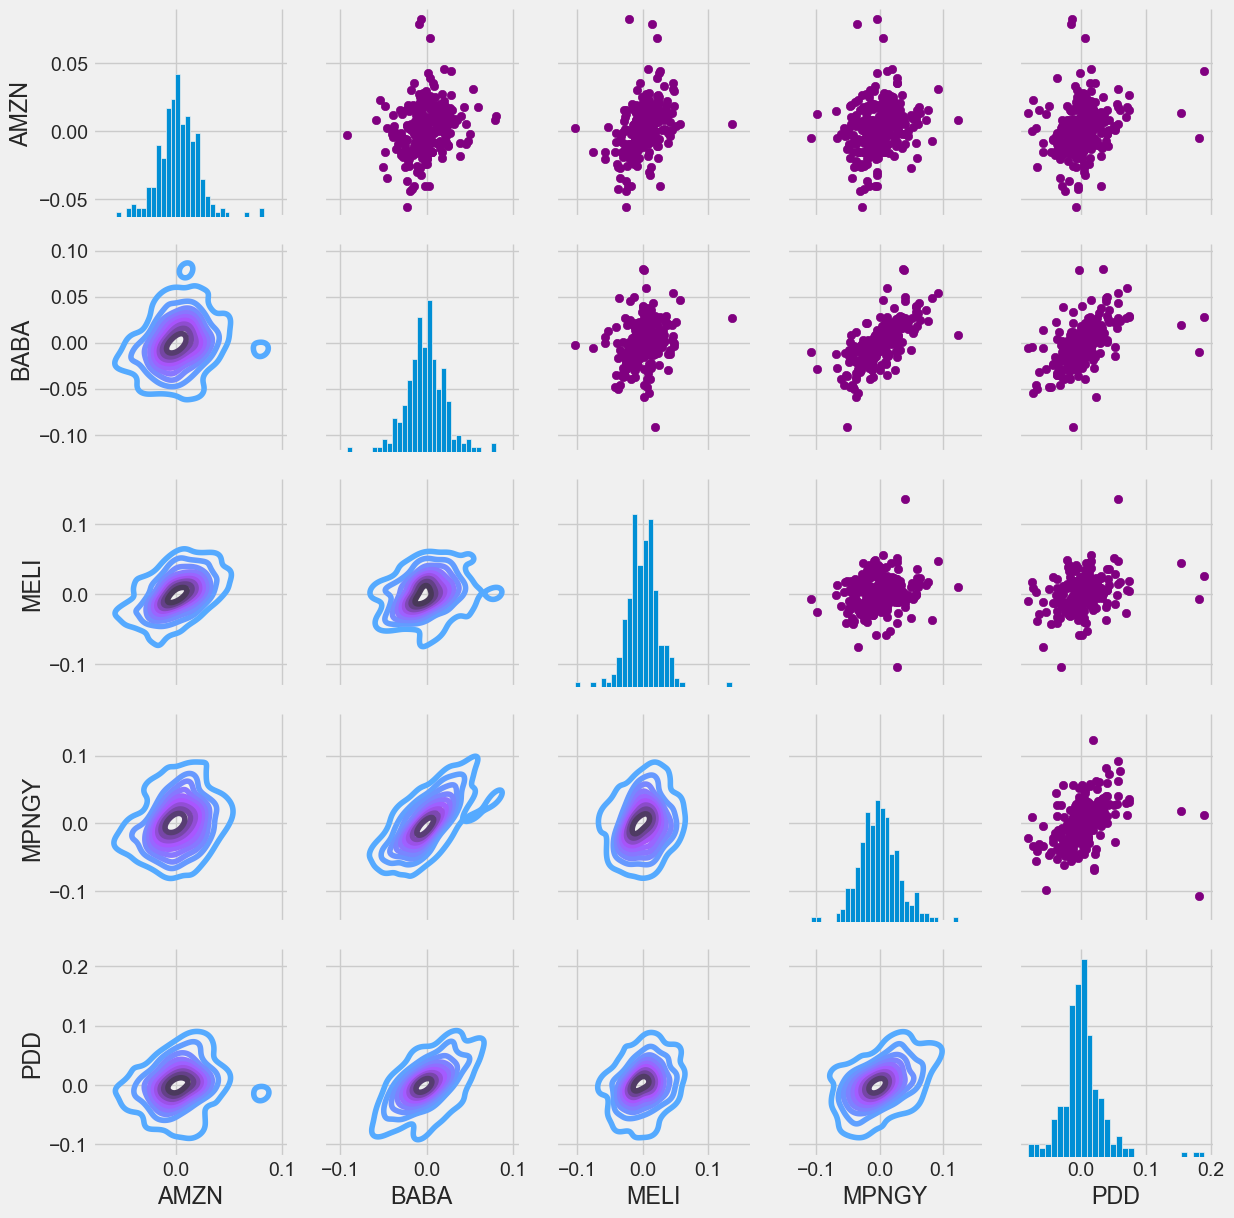

In [32]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(tech_rets.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) 
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

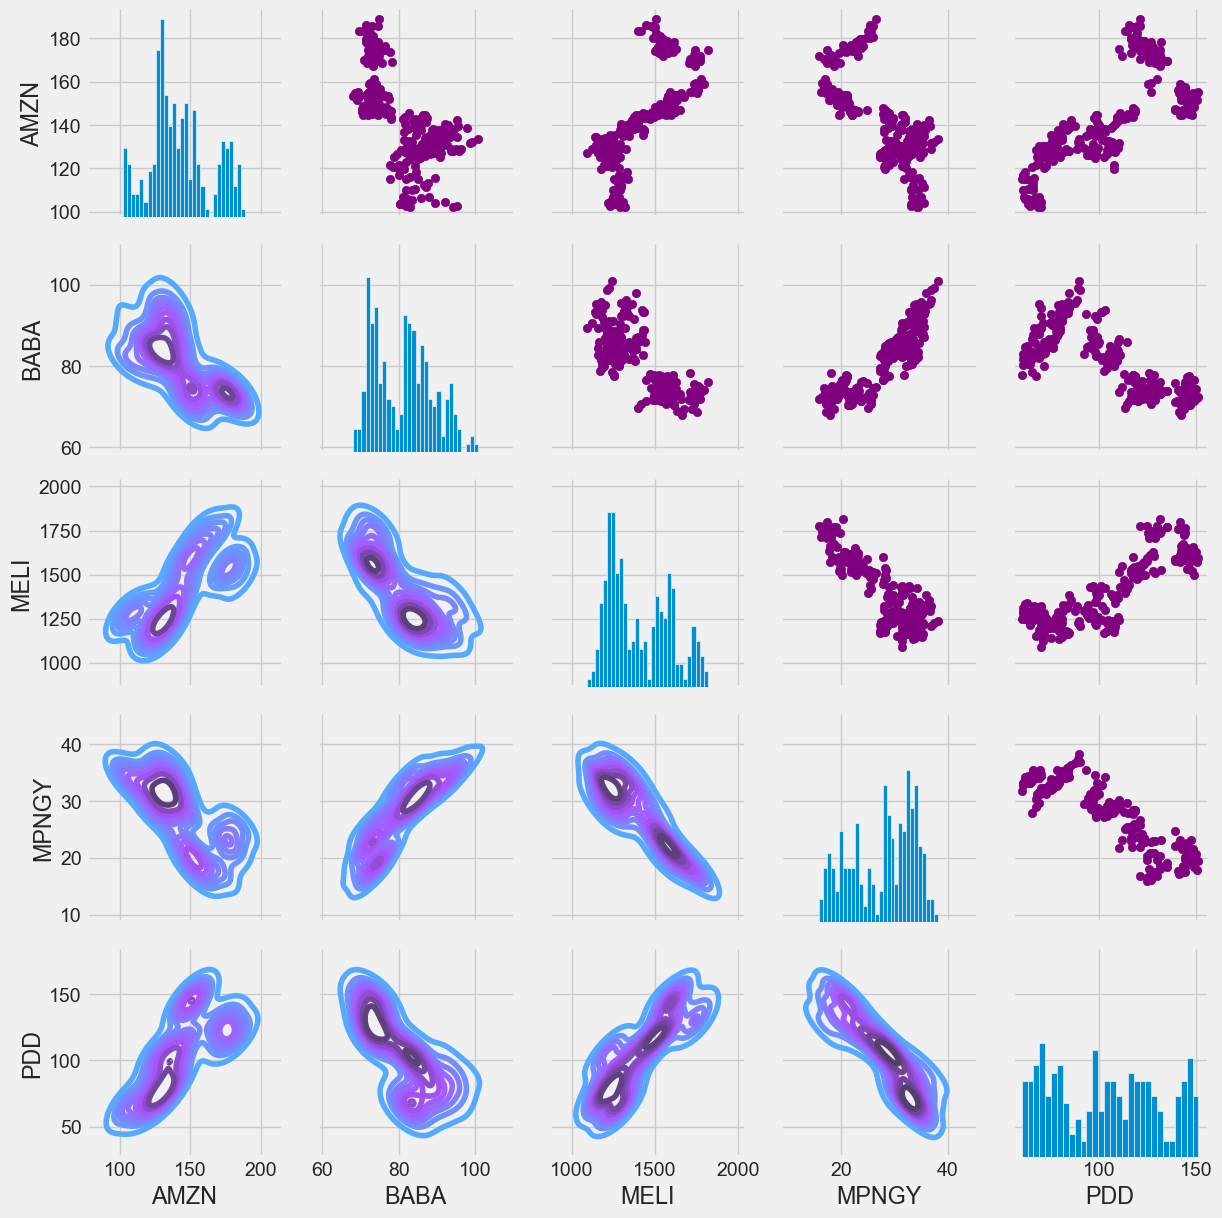

In [59]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(closing_df)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)

Text(0.5, 1.0, 'Correlation of stock closing price')

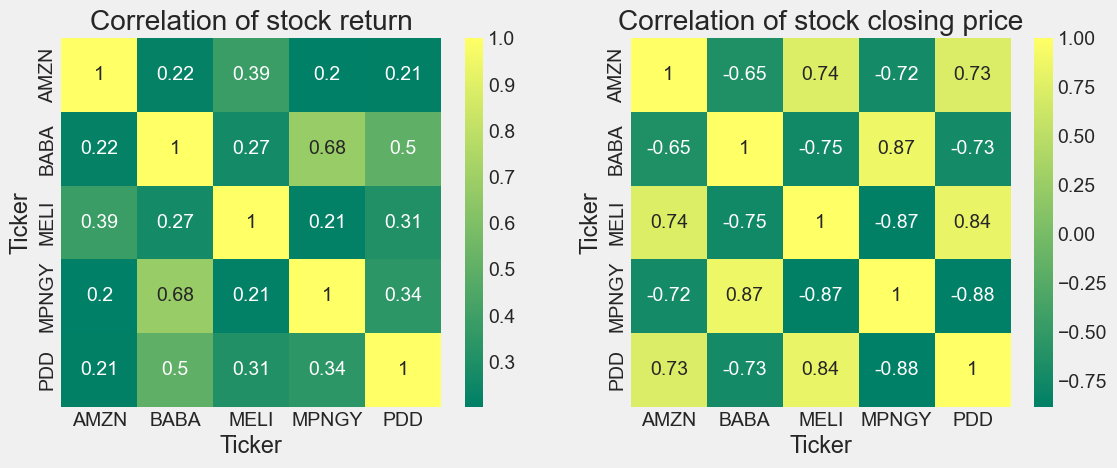

In [33]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

## How much value do we put at risk by investing in a particular stock?

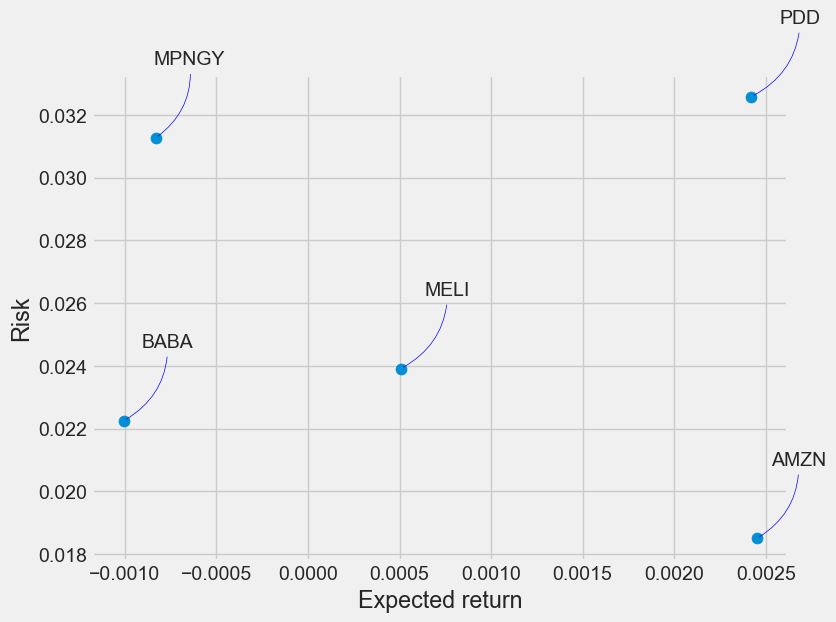

In [34]:
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(8, 6))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

## VaR and CVar analysis

In [121]:
def calculate_var_cvar(df,confidence_level = 0.95):
    prices = df['Close']
    returns = prices.pct_change().dropna()
    
    # VaR
    var = np.percentile(returns, 100 * (1 - confidence_level))
    
    # CVaR
    cvar = returns[returns <= var].mean()
    
    return var, cvar

In [133]:
stock_list = ['AMZN','BABA','PDD','MPNGY','MELI']
VaR_list = [calculate_var_cvar(pdr.get_data_yahoo(i, start='2012-01-01', end=datetime.now()),confidence_level = 0.95)[0] for i in stock_list]
CVaR_list = [calculate_var_cvar(pdr.get_data_yahoo(i, start='2012-01-01', end=datetime.now()),confidence_level = 0.95)[1] for i in stock_list]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [137]:
risk_df = pd.DataFrame({
    'CVaR': CVaR_list,
    'VaR': VaR_list
}, index=stock_list)

risk_df

CVaR       VaR
AMZN  -0.045344 -0.029763
BABA  -0.055475 -0.038237
PDD   -0.095779 -0.068034
MPNGY -0.085664 -0.059634
MELI  -0.065208 -0.043592

In [135]:
# Create a bar chart with matplotlib to visualize these values
fig, ax = plt.subplots(figsize=(10, 6))

# Width of the bars
bar_width = 0.35

# Set the index for the stock_list
index = range(len(stock_list))

# Plot CVaR values as bars
cvar_bar = ax.bar(index, cVaR_list, bar_width, label='CVaR')

# Plot VaR values next to the CVaR bars
var_bar = ax.bar([i + bar_width for i in index], VaR_list, bar_width, label='VaR')

# Add labels and title
ax.set_xlabel('Stocks')
ax.set_ylabel('Values')
ax.set_title('CVaR and VaR by Stock')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(stock_list)
ax.legend()

# Display the chart
plt.tight_layout()
plt.show()


[-0.029763094425170996,
 -0.038237115143948,
 -0.06803418558038346,
 -0.059634078540962226,
 -0.04359206970524165]

#  Stock price predicting

Taking Amazon Inc. as an example.

In [65]:
# Get the stock quote
df = pdr.get_data_yahoo('AMZN', start='2012-01-01', end=datetime.now())
# Show teh data
df

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2012-01-03    8.794500    8.974000    8.777500    8.951500    8.951500   
2012-01-04    8.960500    9.025000    8.803500    8.875500    8.875500   
2012-01-05    8.797000    8.912500    8.702500    8.880500    8.880500   
2012-01-06    8.903500    9.232500    8.875000    9.130500    9.130500   
2012-01-09    9.138000    9.218500    8.850000    8.928000    8.928000   
...                ...         ...         ...         ...         ...   
2024-04-11  186.740005  189.770004  185.509995  189.050003  189.050003   
2024-04-12  187.720001  188.380005  185.080002  186.130005  186.130005   
2024-04-15  187.429993  188.690002  183.000000  183.619995  183.619995   
2024-04-16  183.270004  184.830002  182.259995  183.320007  183.320007   
2024-04-17  184.309998  184.570007  179.820007  181.279999  181.279999   

               Volume  
Date                   
2012-01-03  102216000  
2012-01-04   84104000  
2012-01-05   76182000  
2012-01-06  140168000  
2012-01-09  101138000  
...               ...  
2024-04-11   40020700  
2024-04-12   38554300  
2024-04-15   48052400  
2024-04-16   32891300  
2024-04-17   31305800  

[3092 rows x 6 columns]

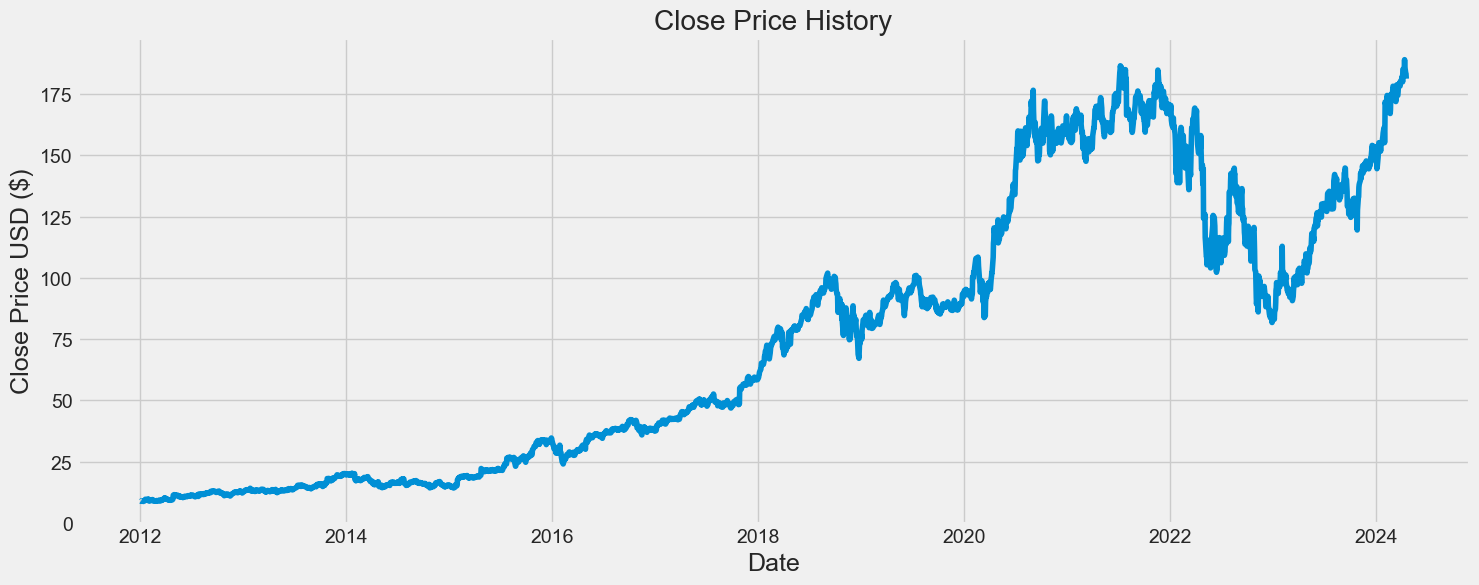

In [66]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

## With method of ARIMA
### Determine ARIMA parameters p,d,q

In [ ]:
def get_best_parameter()

In [80]:
# Assuming 'df' is your DataFrame and it has a 'Close' column
data_to_analyze = df['Close'].copy()

# Ensure data is stationary
result = adfuller(data_to_analyze.dropna())
if result[1] > 0.05:
    # If data is non-stationary, perform first differencing
    d = 1
    data_to_analyze = data_to_analyze.diff().dropna()
else:
    d = 0

# Initialize AIC value
best_aic = float("inf")
best_p = None
best_q = None

# Define ranges for p and q
p_range = range(0, 5)  # Typically p values are not too large
q_range = range(0, 5)  # Same for q

# Iterate over different combinations of p and q
for p in p_range:
    for q in q_range:
        try:
            # Ignore possible fitting errors
            model = ARIMA(data_to_analyze, order=(p, d, q))
            results = model.fit()
            
            # Update best parameters if current model has lower AIC
            if results.aic < best_aic:
                best_aic = results.aic
                best_p = p
                best_q = q
                
        except Exception as e:
            continue

# Output the best model's parameters
print(f"Best ARIMA Model p: {best_p}, d: {d}, q: {best_q}, AIC: {best_aic}")

Best ARIMA Model p: 2, d: 1, q: 3, AIC: 12884.75043846733


### Model training

Initial ADF Statistic: -0.15645870177652424
Initial p-value: 0.9435165125324176


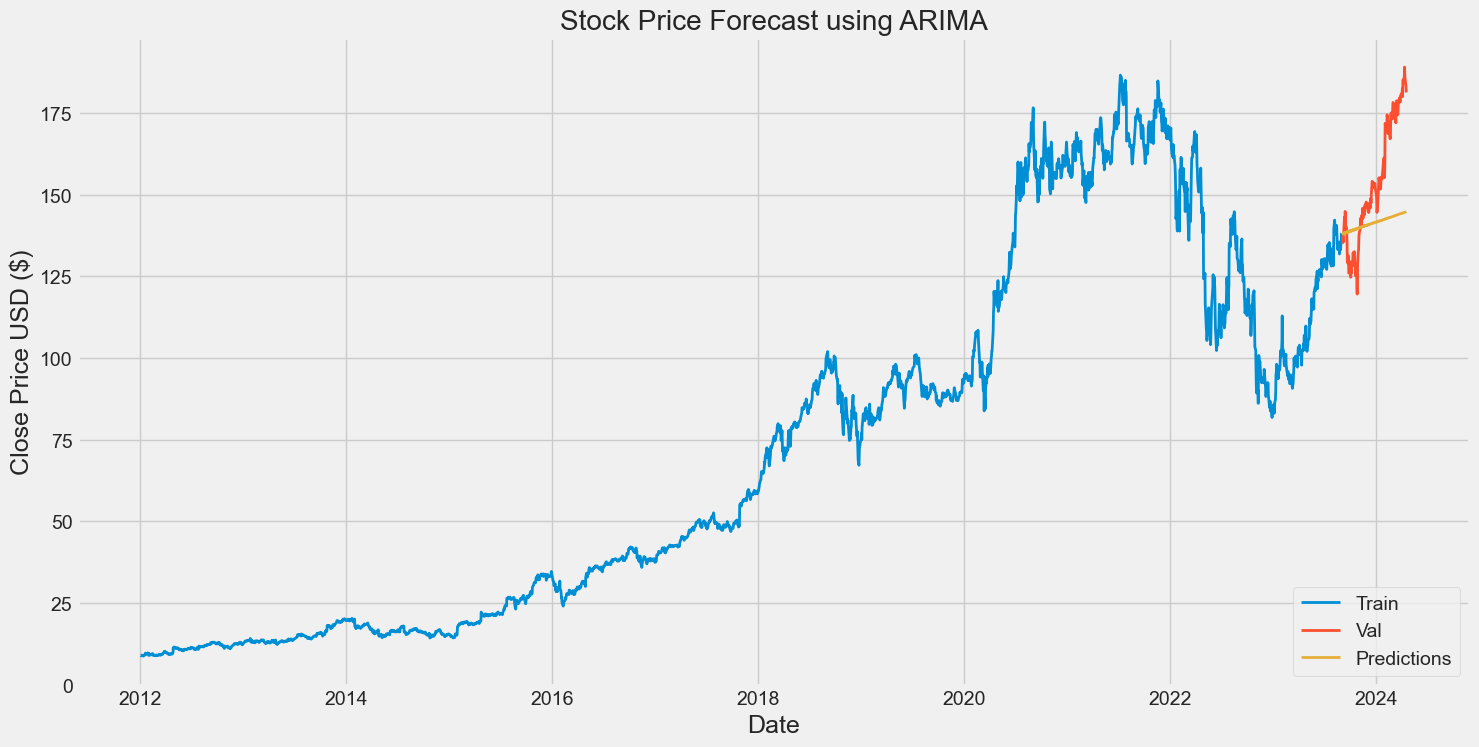

The Root Mean Squared Error of our forecasts is: 20.764873798503388


In [108]:
# Assuming 'df' is your DataFrame and it has a 'Close' column
data_to_analyze = df['Close'].copy()

# Check for stationarity
result = adfuller(data_to_analyze.dropna())
print(f'Initial ADF Statistic: {result[0]}')
print(f'Initial p-value: {result[1]}')

# If non-stationary, perform differencing
if result[1] > 0.05:
    data_to_analyze = data_to_analyze.diff().dropna()
    d = 1
else:
    d = 0

# Split dataset into training and testing sets
train_ratio = 0.95
split_idx = int(len(data_to_analyze) * train_ratio)
train_data = data_to_analyze[:split_idx]
test_data = data_to_analyze[split_idx:]

# Train ARIMA model using the best p and q obtained from AIC
model = ARIMA(train_data, order=(best_p, d, best_q))
fitted_model = model.fit()

# Get the last true value from the training dataset (for inverse differencing)
last_train_value = df['Close'].iloc[split_idx - 1]

# Make predictions
forecast_steps = len(df) - split_idx  # Ensure forecast steps equal the length of the test set
predicted_diff = fitted_model.get_forecast(steps=forecast_steps).predicted_mean

# Cumulative sum of differenced predictions to reverse-transform back to original scale
predicted_prices = last_train_value + np.cumsum(predicted_diff)

# Prepare DataFrame for testing data and predictions
test_data_df = df.iloc[split_idx:].copy()
test_data_df['Predictions'] = predicted_prices.values


### Visualization and evaluation of fitting effects

In [ ]:

# Visualization
plt.figure(figsize=(16,8))
plt.title('Stock Price Forecast using ARIMA')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df['Close'][:split_idx], label='Train Data', linewidth=2)
plt.plot(test_data_df[['Close', 'Predictions']], label=['Test Data', 'Predictions'], linewidth=2)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Calculate RMSE
rmse = sqrt(mean_squared_error(test_data_df['Close'], test_data_df['Predictions']))
print('The Root Mean Squared Error of our forecasts is:', rmse)

### Relationship between the prediction effect of ARIMA model and the proportion of training set

In [37]:
def price_pred_plot_ARIMA(ticker,train_ratio):
    # Get the stock quote
    df = pdr.get_data_yahoo(ticker, start='2012-01-01', end=datetime.now())
    # Assuming 'df' is your DataFrame and it has a 'Close' column
    data_to_analyze = df['Close'].copy()

    # Ensure data is stationary
    result = adfuller(data_to_analyze.dropna())
    if result[1] > 0.05:
        # If data is non-stationary, perform first differencing
        d = 1
        data_to_analyze = data_to_analyze.diff().dropna()
    else:
        d = 0

    # Initialize AIC value
    best_aic = float("inf")
    best_p = None
    best_q = None

    # Define ranges for p and q
    p_range = range(0, 5)  # Typically p values are not too large
    q_range = range(0, 5)  # Same for q

    # Iterate over different combinations of p and q
    for p in p_range:
        for q in q_range:
            try:
                # Ignore possible fitting errors
                model = ARIMA(data_to_analyze, order=(p, d, q))
                results = model.fit()

                # Update best parameters if current model has lower AIC
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_p = p
                    best_q = q

            except Exception as e:
                continue

    # Output the best model's parameters

    # Assuming 'df' is your DataFrame and it has a 'Close' column
    data_to_analyze = df['Close'].copy()

    # Check for stationarity
    result = adfuller(data_to_analyze.dropna())

    # If non-stationary, perform differencing
    if result[1] > 0.05:
        data_to_analyze = data_to_analyze.diff().dropna()
        d = 1
    else:
        d = 0

    # Split dataset into training and testing sets
    split_idx = int(len(data_to_analyze) * train_ratio)
    train_data = data_to_analyze[:split_idx]
    test_data = data_to_analyze[split_idx:]

    # Train ARIMA model using the best p and q obtained from AIC
    model = ARIMA(train_data, order=(best_p, d, best_q))
    fitted_model = model.fit()

    # Get the last true value from the training dataset (for inverse differencing)
    last_train_value = df['Close'].iloc[split_idx - 1]

    # Make predictions
    forecast_steps = len(df) - split_idx  # Ensure forecast steps equal the length of the test set
    predicted_diff = fitted_model.get_forecast(steps=forecast_steps).predicted_mean

    # Cumulative sum of differenced predictions to reverse-transform back to original scale
    predicted_prices = last_train_value + np.cumsum(predicted_diff)

    # Prepare DataFrame for testing data and predictions
    test_data_df = df.iloc[split_idx:].copy()
    test_data_df['Predictions'] = predicted_prices.values

    # Visualization
    plt.figure(figsize=(16,8))
    plt.title('Stock Price Forecast using ARIMA')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(df['Close'][:split_idx], label='Train Data', linewidth=2)
    plt.plot(test_data_df[['Close', 'Predictions']], label=['Test Data', 'Predictions'], linewidth=2)
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

    # Calculate RMSE
    rmse = sqrt(mean_squared_error(test_data_df['Close'], test_data_df['Predictions']))

    # Calculate NRMSE (Normalized RMSE)
    close_range = test_data_df['Close'].max() - test_data_df['Close'].min()
    nrmse = rmse / close_range if close_range != 0 else None

    # Extract predicted close price list
    predicted_close_prices = predicted_prices.tolist()

    # Return RMSE, NRMSE, and the list of predicted close prices
    return rmse, nrmse, predicted_close_prices

[*********************100%%**********************]  1 of 1 completed


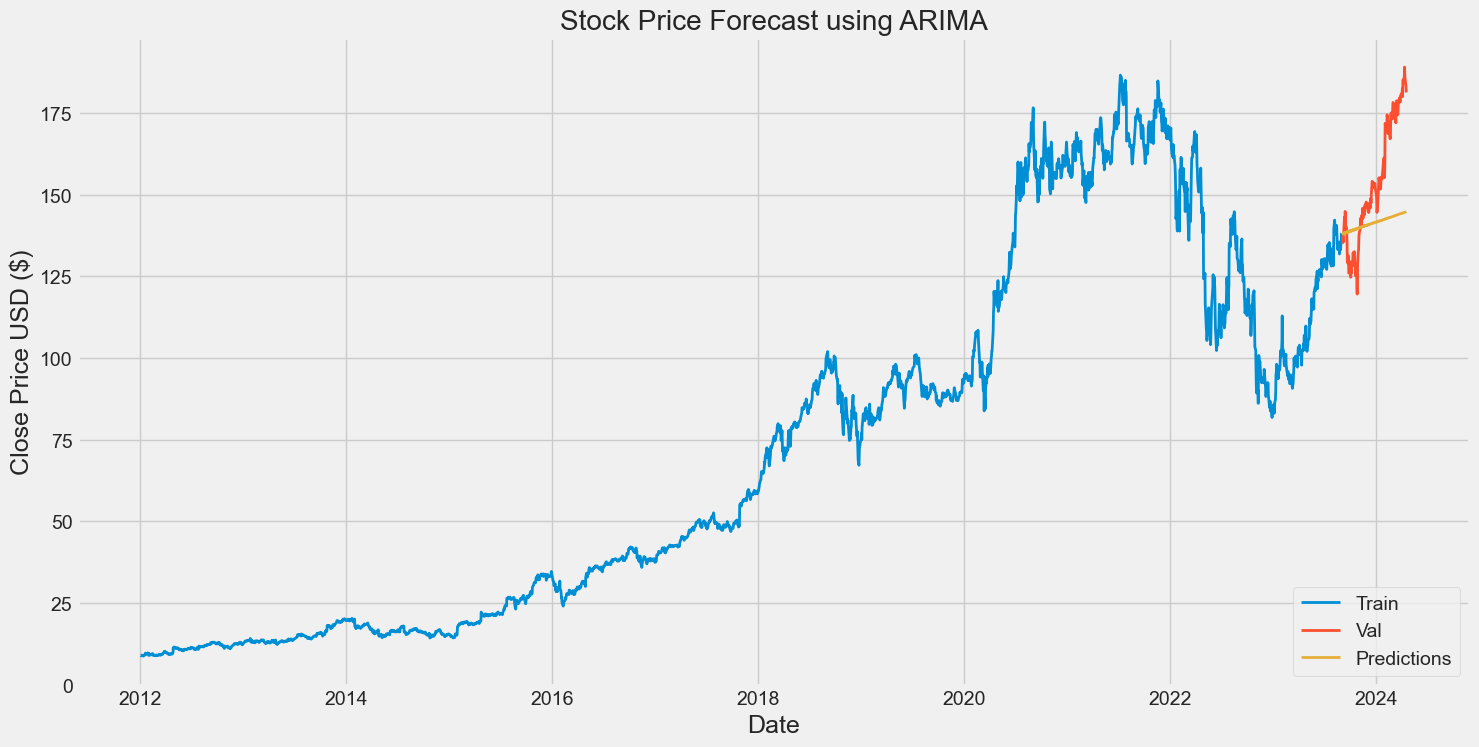

20.764873798503388

In [112]:
price_pred_plot_ARIMA('AMZN',0.95)

[*********************100%%**********************]  1 of 1 completed


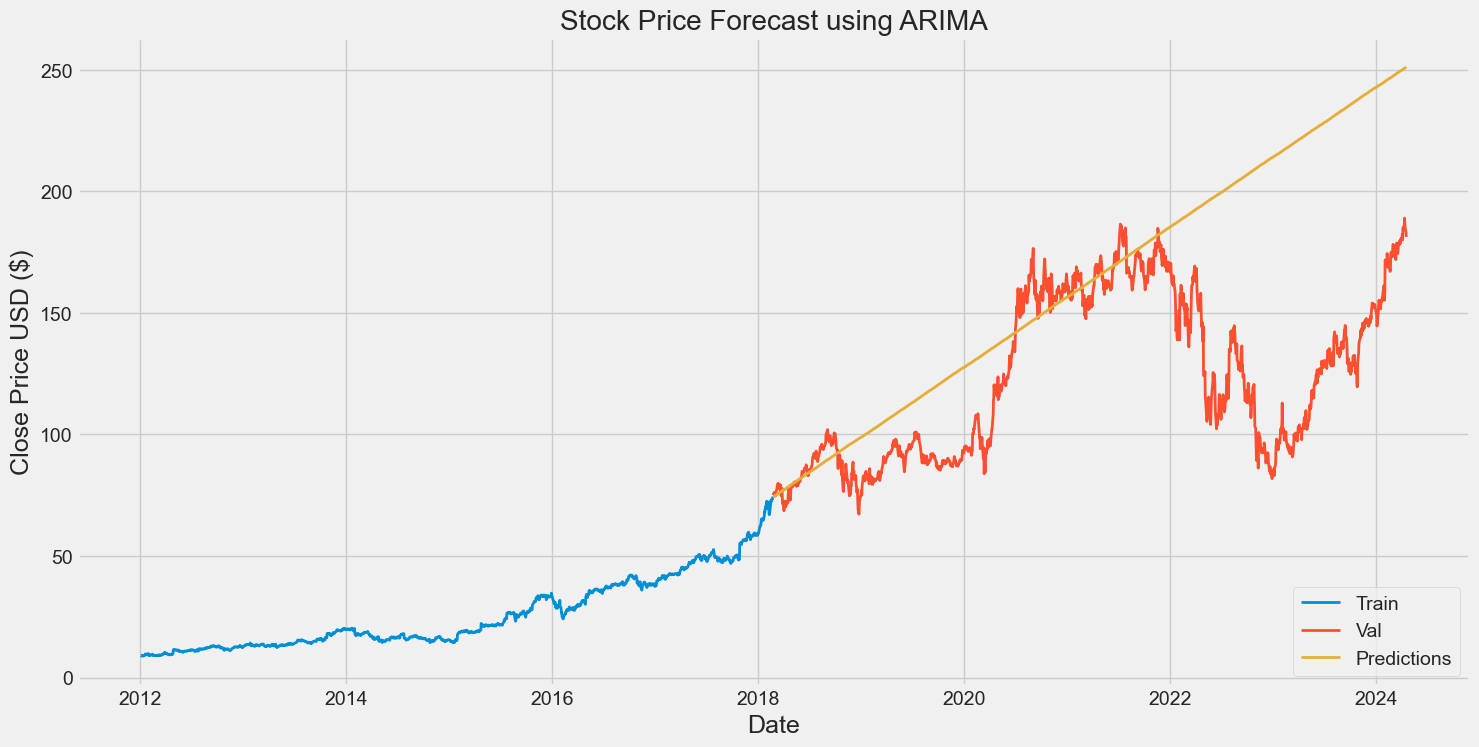

[*********************100%%**********************]  1 of 1 completed


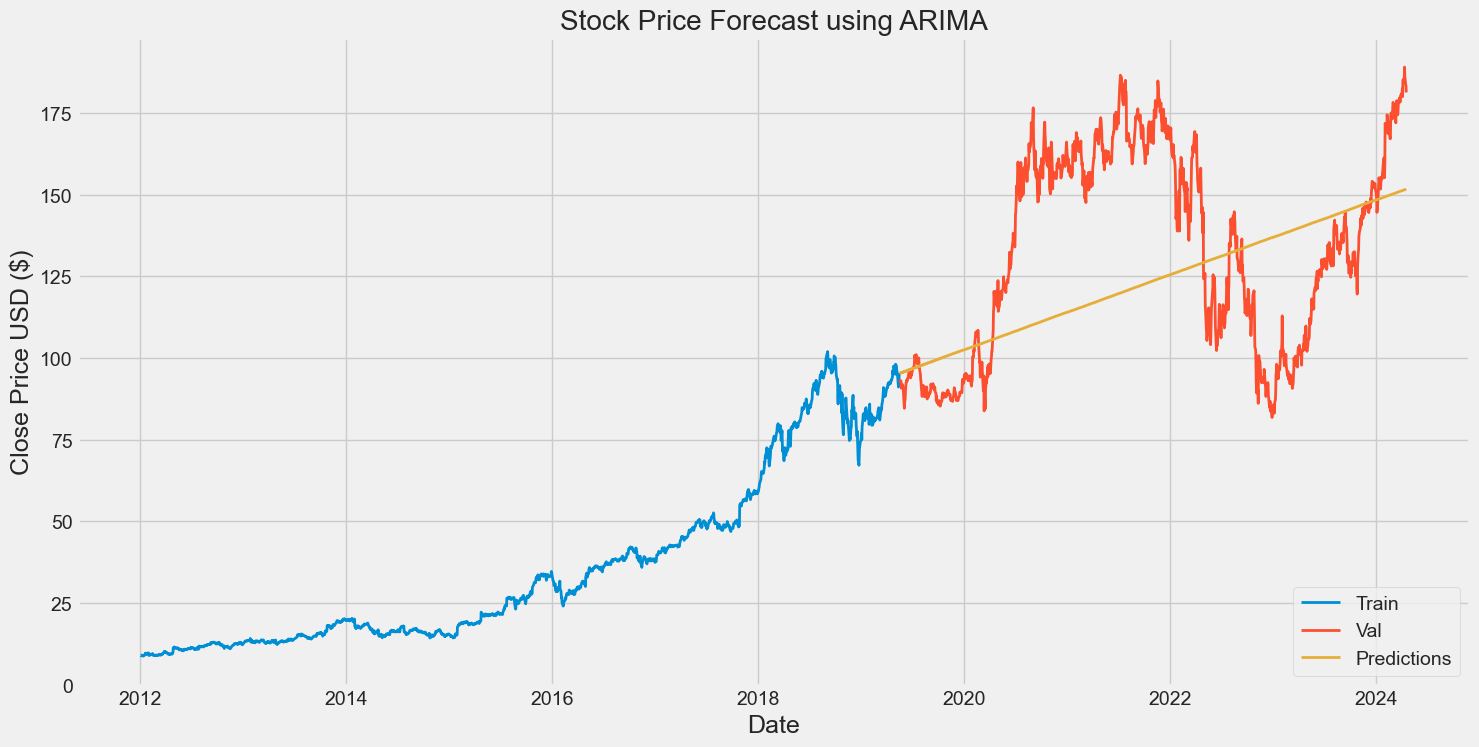

[*********************100%%**********************]  1 of 1 completed


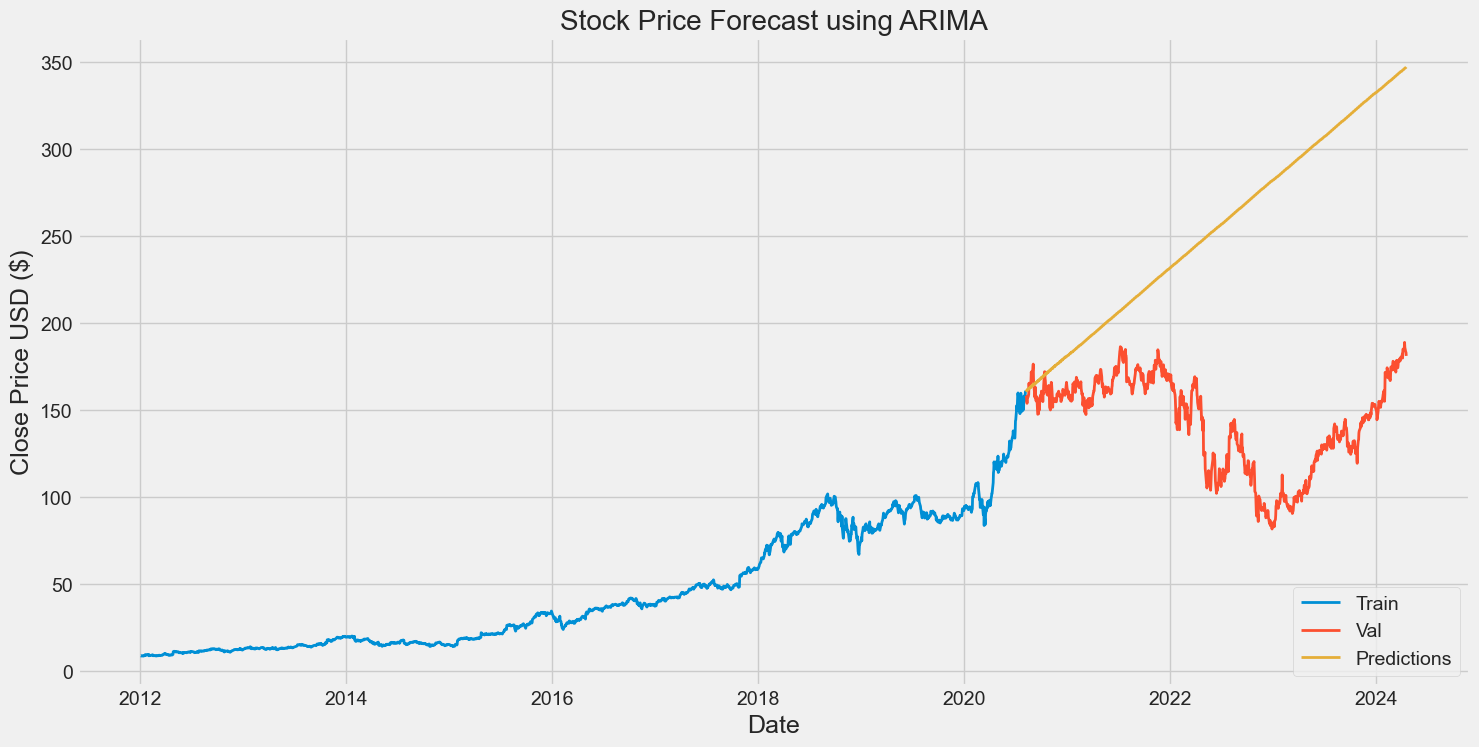

[*********************100%%**********************]  1 of 1 completed


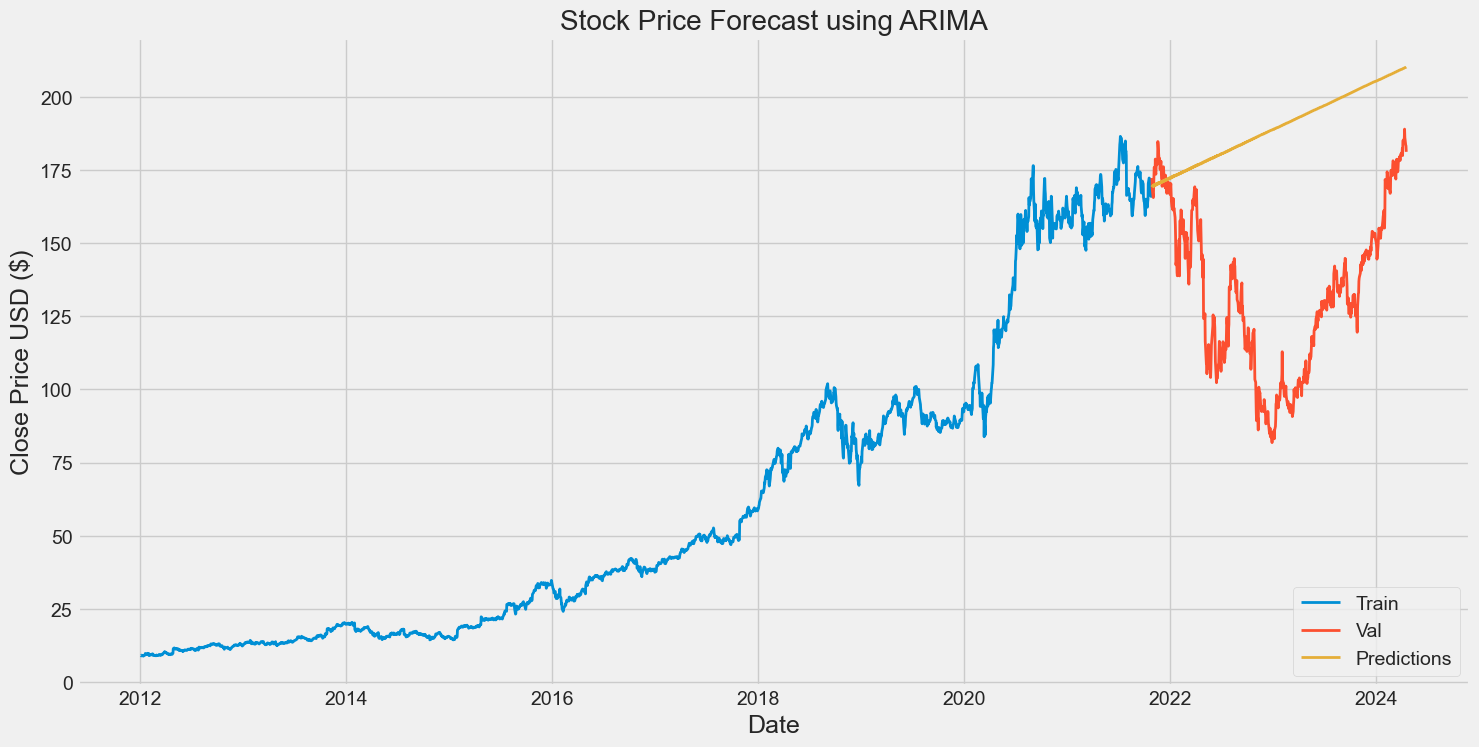

[*********************100%%**********************]  1 of 1 completed


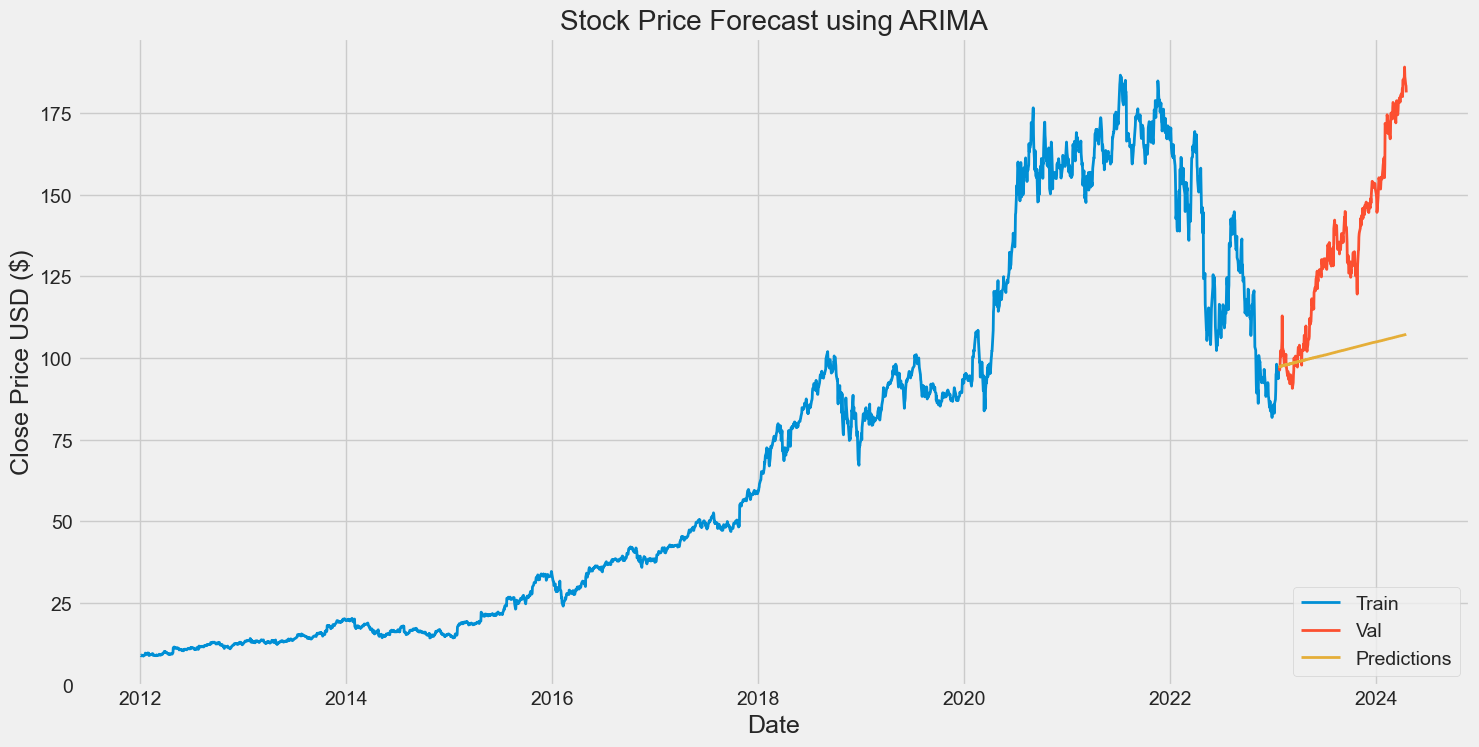

[*********************100%%**********************]  1 of 1 completed


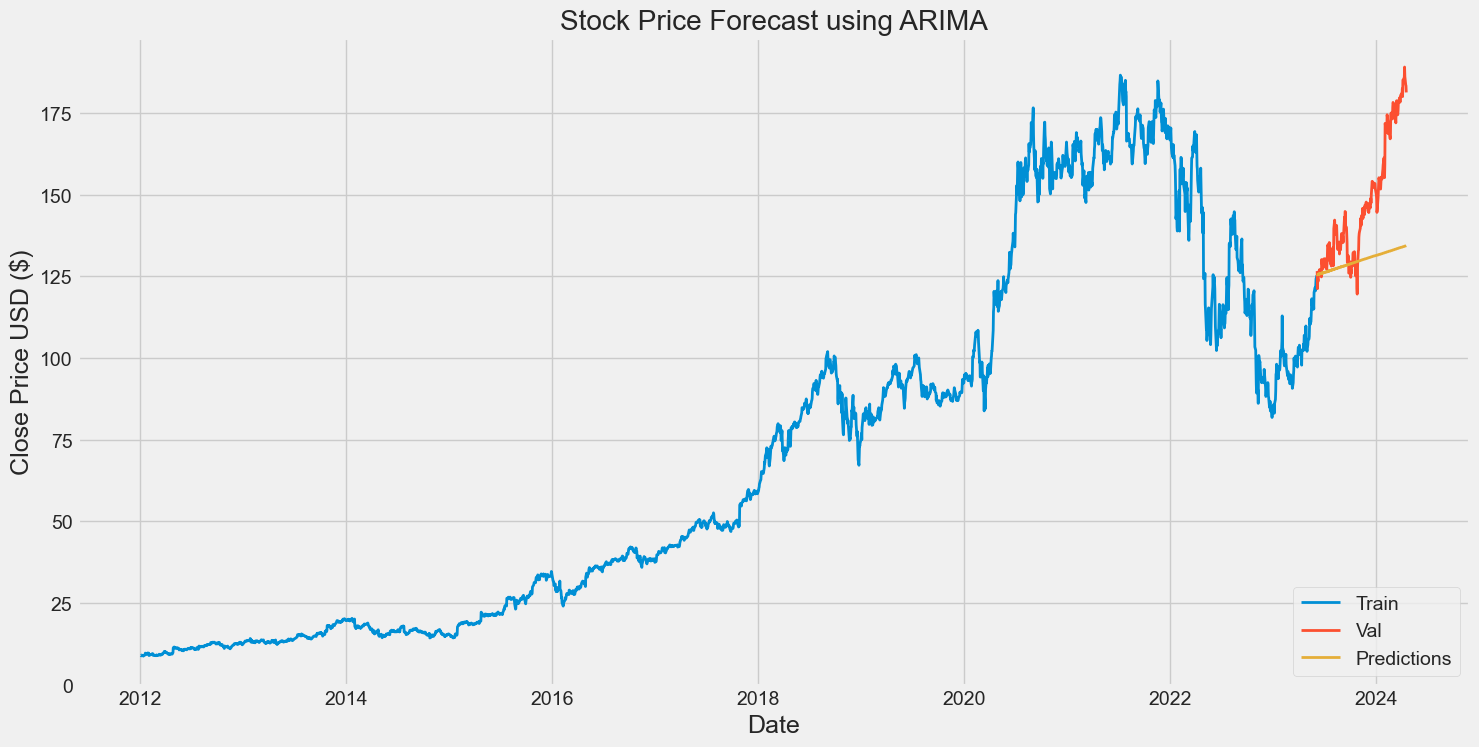

[*********************100%%**********************]  1 of 1 completed


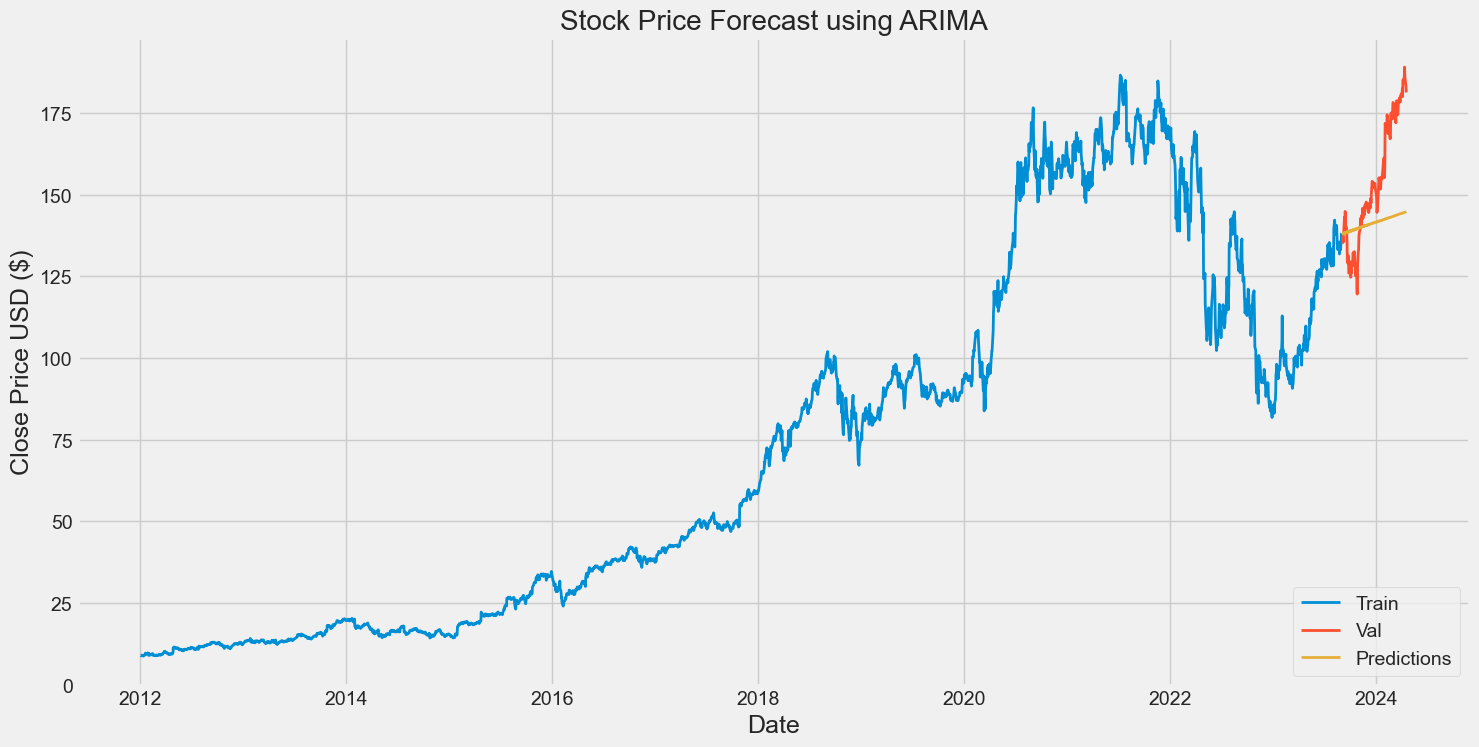

[*********************100%%**********************]  1 of 1 completed


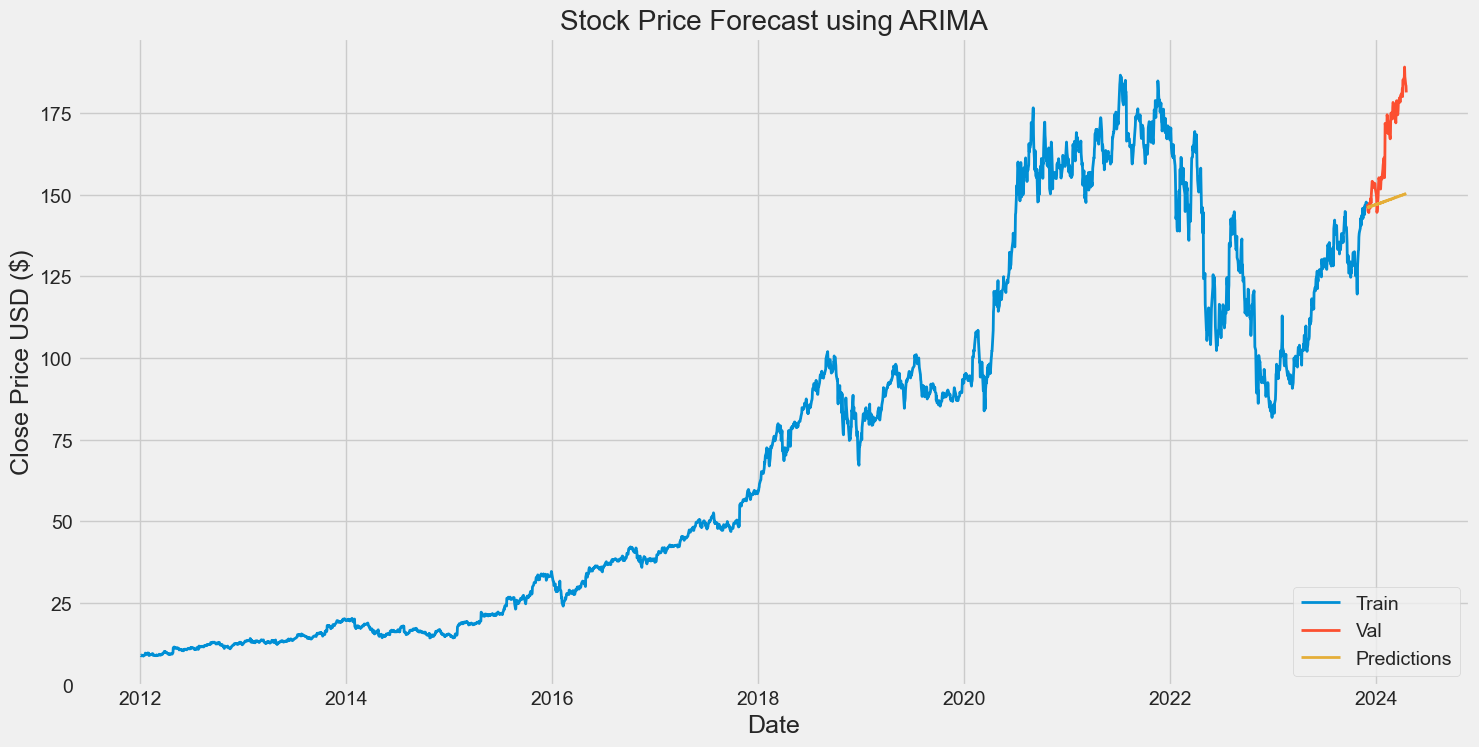

[*********************100%%**********************]  1 of 1 completed


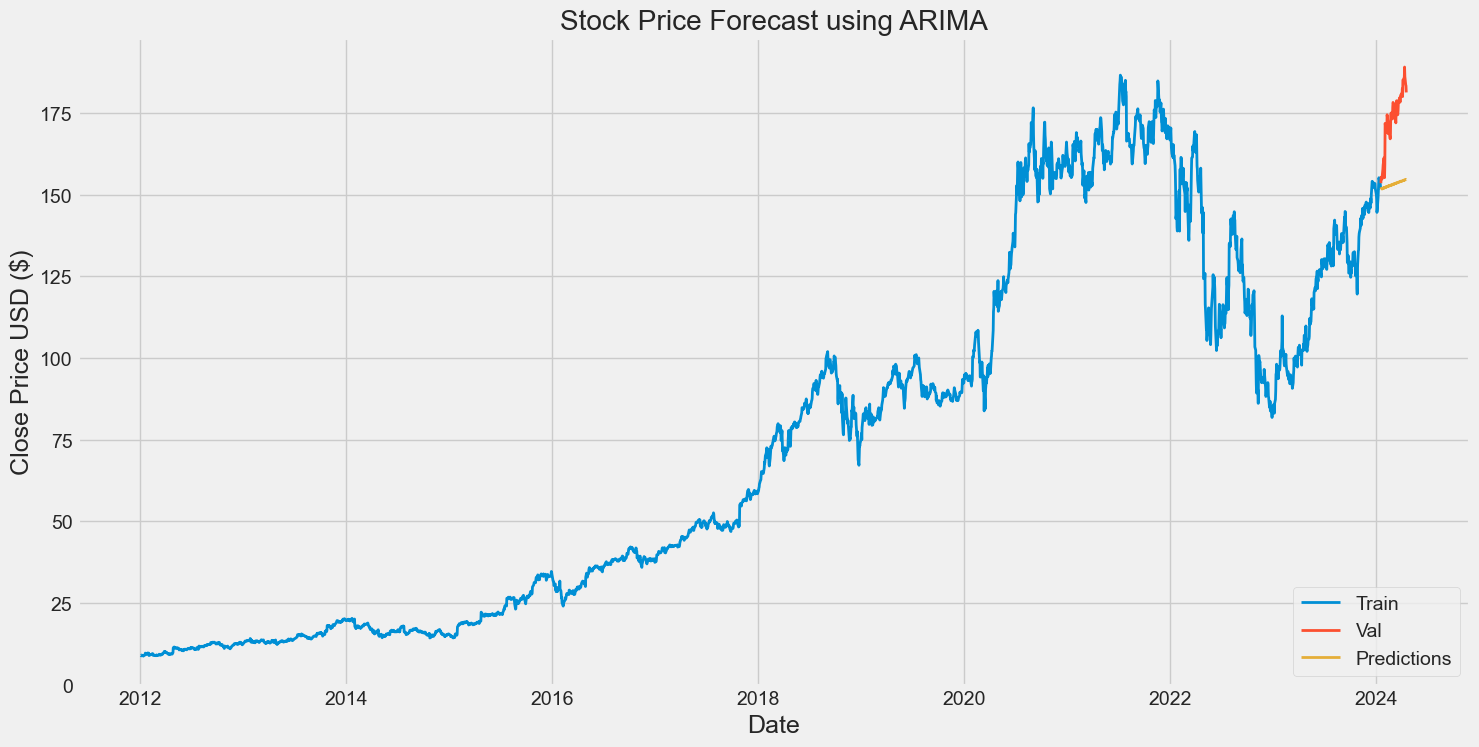

[*********************100%%**********************]  1 of 1 completed


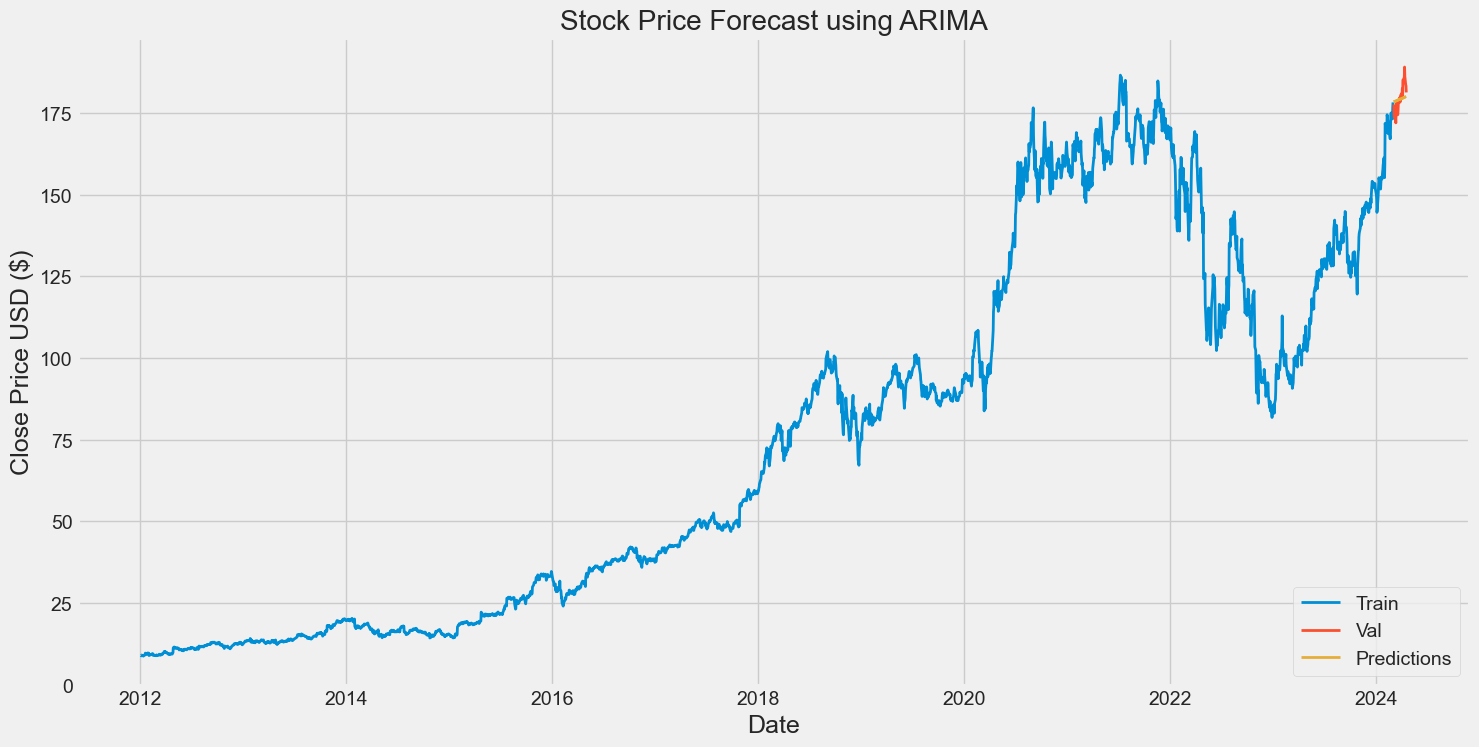

[*********************100%%**********************]  1 of 1 completed


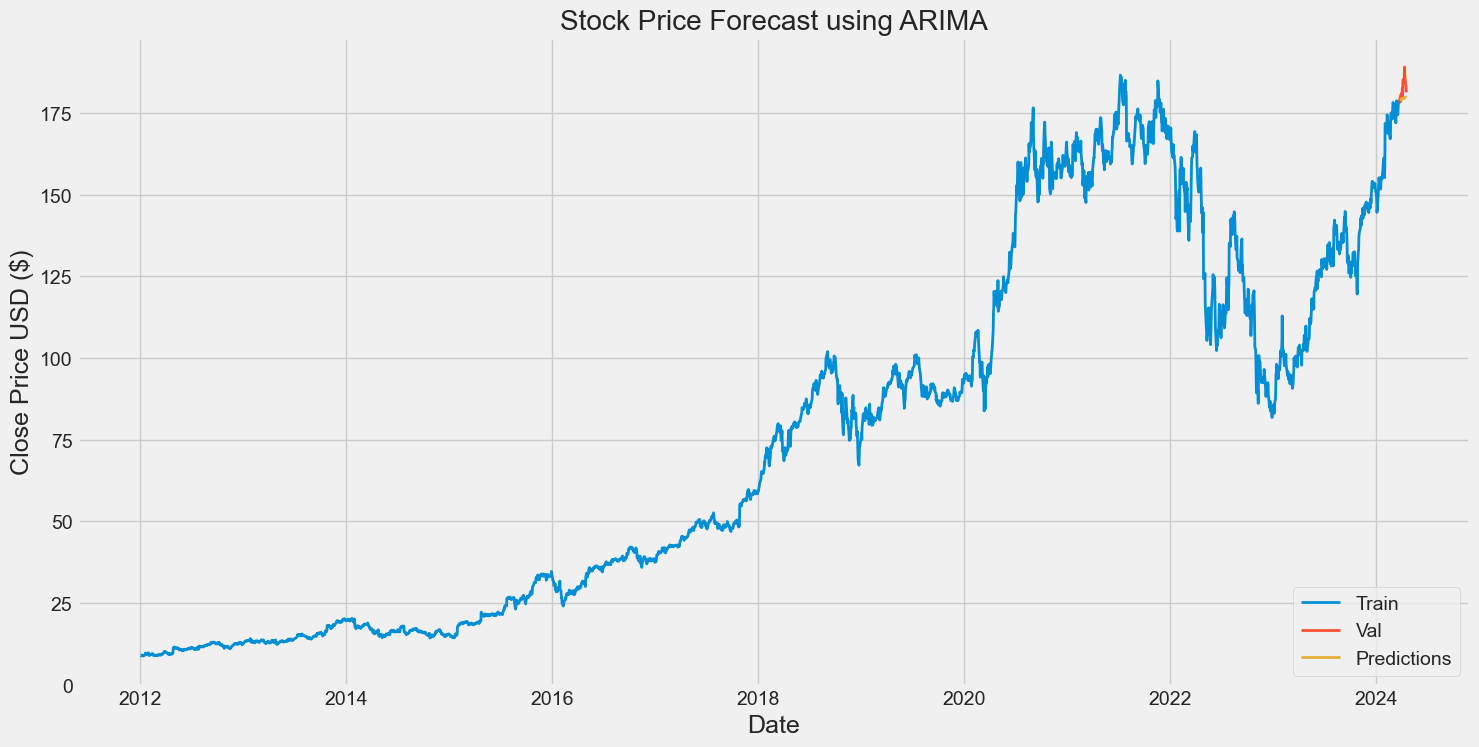

In [113]:
list_of_ratio = [0.5,0.6,0.7,0.8,0.9,0.93,0.95,0.97,0.98,0.99,0.995]
rmse_list = []
for i in list_of_ratio:
    rmse_list.append(price_pred_plot_ARIMA('AMZN',i))

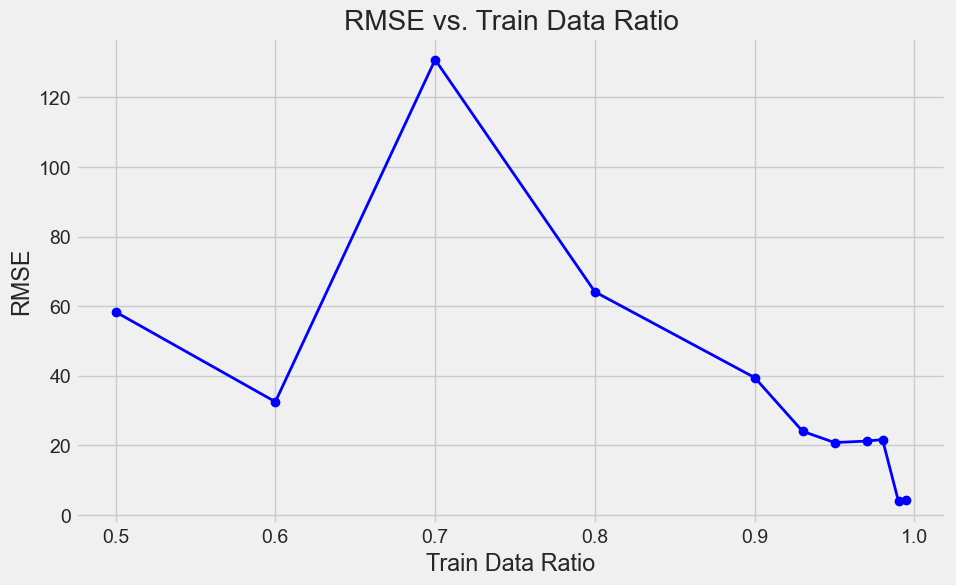

In [116]:
plt.figure(figsize=(10, 6))
plt.plot(list_of_ratio, rmse_list, marker='o', color='b', linestyle='-',linewidth=2)
plt.title('RMSE vs. Train Data Ratio')
plt.xlabel('Train Data Ratio')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

We can see that due to the very irregular magnitude and direction of stock movements, the simpler ARIMA model does not perform well in long term forecasting, and the overall forecasting effect (here denoted by RMSE) is positively correlated with the proportion of the training set and negatively correlated with the proportion of the test set. The ARIMA model is not good at capturing information in the face of more complex stock price movements, and its prediction results look too linear compared to the stock price volatility, and are only valid for a short period of time, so we introduce another method: LSTM.

### ARIMA Rolling

In [2]:
def optimize_arima_params(data):
    # Check stationarity and determine 'd'
    result = adfuller(data.dropna())
    d = 1 if result[1] > 0.05 else 0
    if d == 1:
        data = data.diff().dropna()
    
    best_aic = np.inf
    best_p = None
    best_q = None
    best_d = d
    
    # Define ranges for p and q
    p_range = range(0, 5)
    q_range = range(0, 5)
    
    # Iterate over different combinations of p and q
    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(data, order=(p, d, q))
                results = model.fit()
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_p = p
                    best_q = q
                    best_d = d
            except:
                continue
    
    return best_p, best_d, best_q, best_aic

In [166]:
def rolling_arima_prediction(ticker, train_ratio, window_size):
    # Get the stock data
    df = pdr.get_data_yahoo(ticker, start='2012-01-01', end=datetime.now())
    
    # Use the 'Close' column
    data_to_analyze = df['Close'].copy()
    
    # Split dataset into training and testing sets
    split_idx = int(len(data_to_analyze) * train_ratio)
    train_data = data_to_analyze[:split_idx]
    test_data = data_to_analyze[split_idx:]
    
    predictions = []
    
    for end in range(split_idx, len(data_to_analyze)):
        start = max(0, end - window_size)
        rolling_train_data = data_to_analyze[start:end]
        
        # Optimize ARIMA parameters for the rolling window
        best_p, best_d, best_q, _ = optimize_arima_params(rolling_train_data)
        
        # Fit ARIMA model
        model = ARIMA(rolling_train_data, order=(best_p, best_d, best_q))
        fitted_model = model.fit()
        
        # Forecast the next step
        forecast = fitted_model.forecast(steps=1)
        predictions.append(forecast)
    
    # Reverse differencing if applicable
    # Reverse differencing if applicable
    if best_d == 1:
        first_value = df['Close'].iloc[split_idx]
        # Flatten 'predictions' to a 1D array
        predictions_flattened = np.array(predictions).ravel()

        # Concatenate 'first_value' with the flattened 'predictions_flattened'
        predictions_combined = np.concatenate(([first_value], predictions_flattened))

        # Calculate the cumulative sum to reverse the differencing
        final_predictions = predictions_combined.cumsum()
    else:
        final_predictions = np.array(predictions).ravel()  # Flatten if necessary, ensuring it is a 1D array if not already
    
    # Prepare DataFrame for testing data and predictions
    test_data_df = df.iloc[split_idx:].copy()
    test_data_df['Predictions'] = predictions
    
    # Visualization
    plt.figure(figsize=(16,8))
    plt.title('Stock Price Forecast using Rolling ARIMA')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(df['Close'][:split_idx], label='Train Data', linewidth=2)
    plt.plot(test_data_df[['Close', 'Predictions']], label=['Test Data', 'Predictions'], linewidth=2)
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()
    
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(test_data_df['Close'], test_data_df['Predictions']))

    # Calculate NRMSE (Normalized RMSE)
    close_range = test_data_df['Close'].max() - test_data_df['Close'].min()
    nrmse = rmse / close_range if close_range != 0 else None

    # Extract predicted close price list
    predicted_close_prices = test_data_df['Predictions']
    Close_list = test_data_df['Close'].values.tolist()
    Prediction_list = [i.values.tolist()[0] for i in predicted_close_prices.tolist()]
    valid = pd.DataFrame({
        'Close':Close_list,
        'Prediction':Prediction_list
    },index=test_data_df.index)

    # Return RMSE, NRMSE, and the list of predicted close prices
    return rmse, nrmse, valid

[*********************100%%**********************]  1 of 1 completed


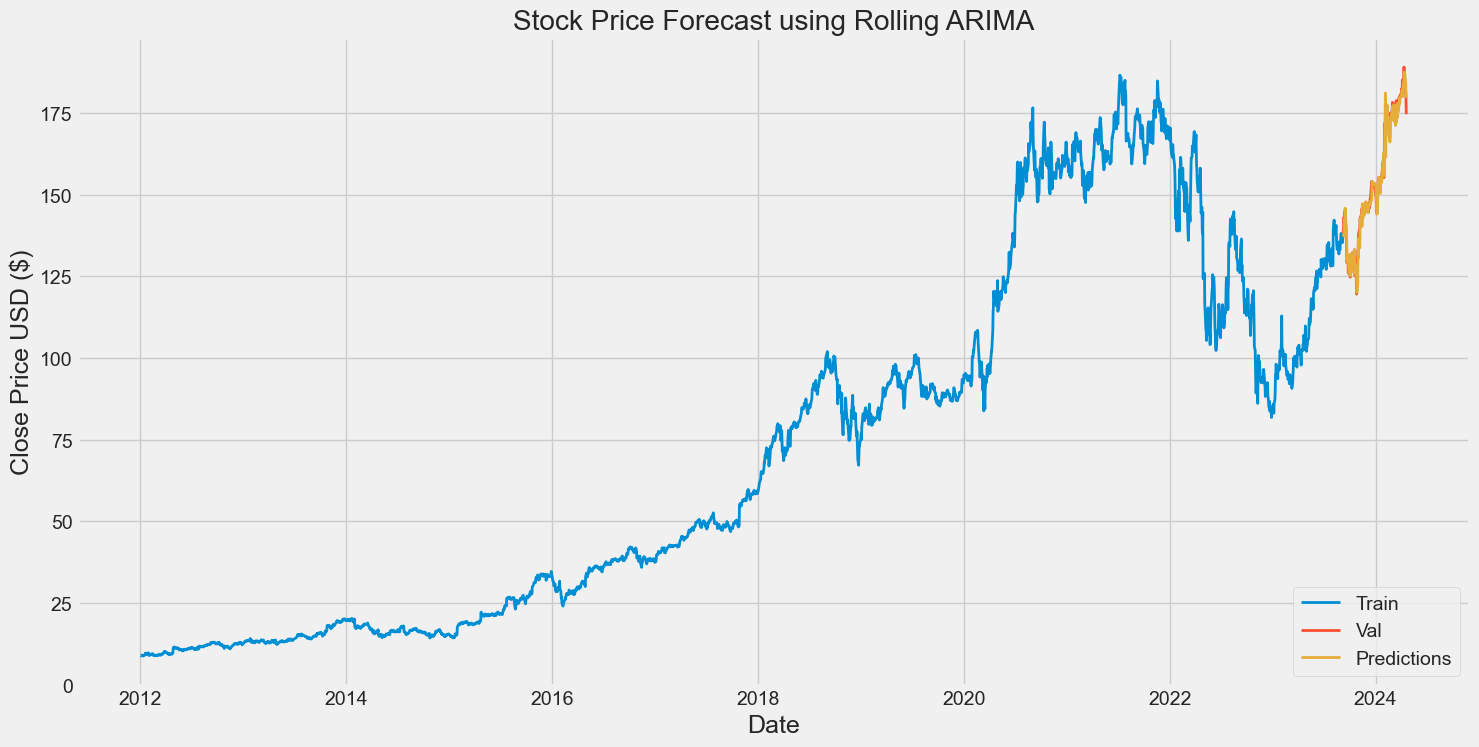

In [167]:
rmse, nrmse, valid = rolling_arima_prediction('AMZN',0.95,30)

In [168]:
valid

Close  Prediction
Date                              
2023-09-08  138.229996  137.805966
2023-09-11  143.100006  137.336797
2023-09-12  141.229996  142.345787
2023-09-13  144.850006  140.538190
2023-09-14  144.720001  141.918696
...                ...         ...
2024-04-15  183.619995  186.453303
2024-04-16  183.320007  184.627883
2024-04-17  181.279999  183.951247
2024-04-18  179.220001  181.973435
2024-04-19  174.630005  179.623152

[155 rows x 2 columns]

In [148]:
# This will extract just the numerical values, ignoring the index.
close_prices = [i.values.tolist()[0] for i in predicted_close_prices.tolist()]
close_prices

[137.80596631944036,
 137.33679679524687,
 142.3457873129654,
 140.5381897570081,
 141.91869602459238,
 145.87564044659283,
 141.2353633281341,
 140.67244008338818,
 137.93864856014554,
 135.48803881586466,
 129.61703553838015,
 129.11949406479272,
 131.32796606062846,
 128.843394607276,
 127.64019029509204,
 125.9812211443795,
 127.05349736144194,
 131.79790032914133,
 125.1221545239191,
 126.80837733327743,
 126.04024214569736,
 127.77136394020697,
 128.21372406232388,
 129.3565230789386,
 131.60793837191454,
 132.27164745129937,
 130.01516381740876,
 132.26250860125873,
 133.29015280773427,
 128.91501738637803,
 128.23997177136087,
 125.49891971820057,
 125.32630727469254,
 128.35724585280255,
 123.17681962563921,
 120.10454759479371,
 123.4136789581757,
 132.6220493726682,
 130.62503006936305,
 136.69678571761946,
 133.5427079525855,
 133.76584974354378,
 138.14992821960914,
 142.8314824677623,
 142.05954857768165,
 140.57262405528232,
 143.81608959285063,
 140.2724410632532,
 147.

In [137]:
# This line converts the Series to a list of values.
values_list = predicted_close_prices.values.tolist()


[*********************100%%**********************]  1 of 1 completed


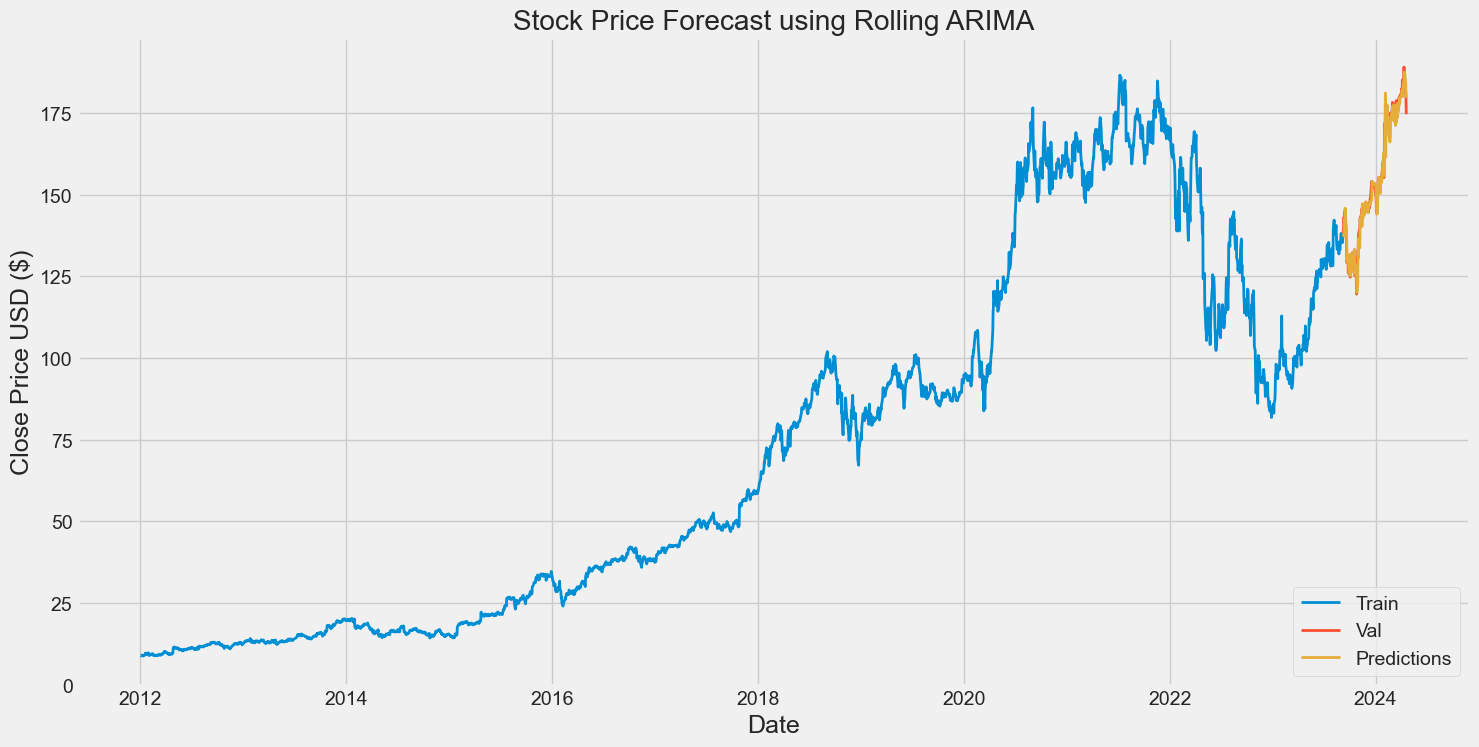

[*********************100%%**********************]  1 of 1 completed


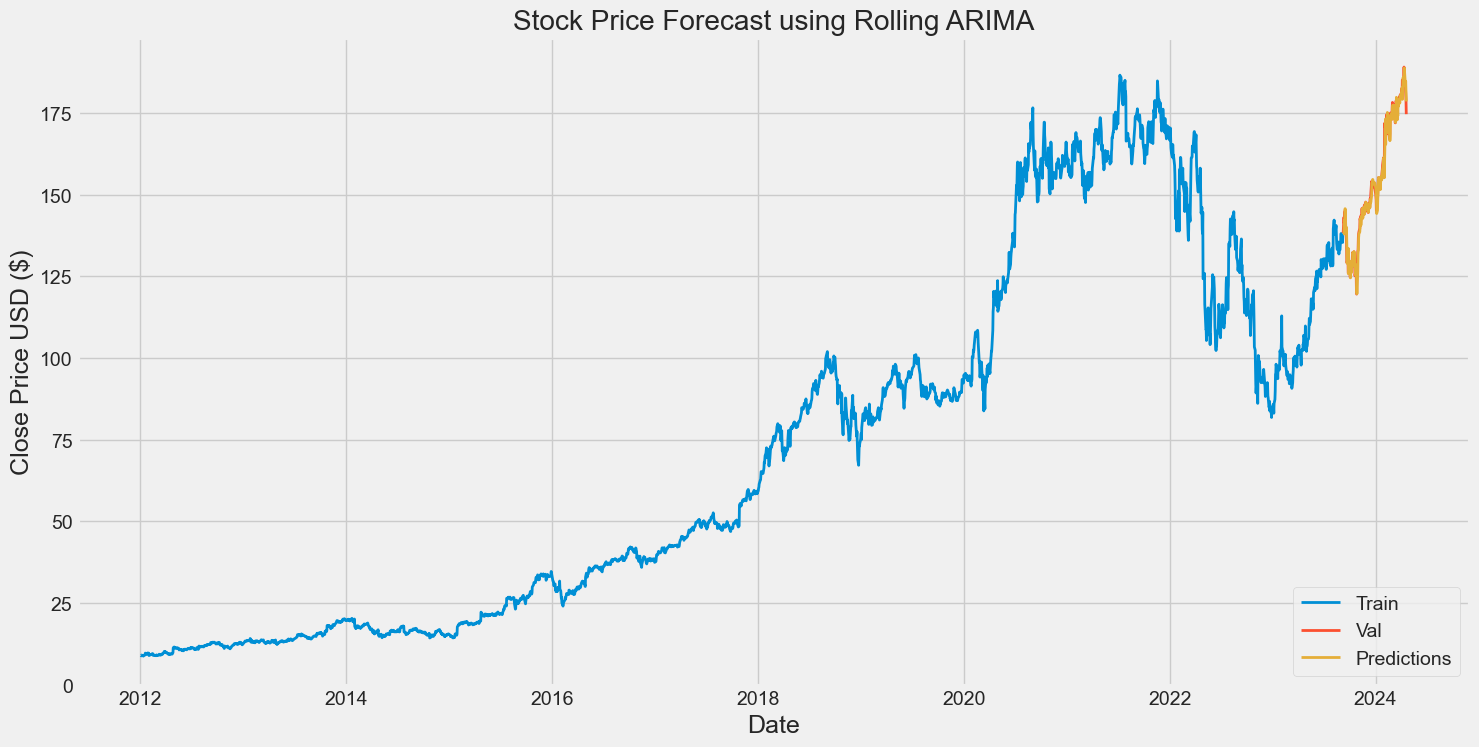

[*********************100%%**********************]  1 of 1 completed


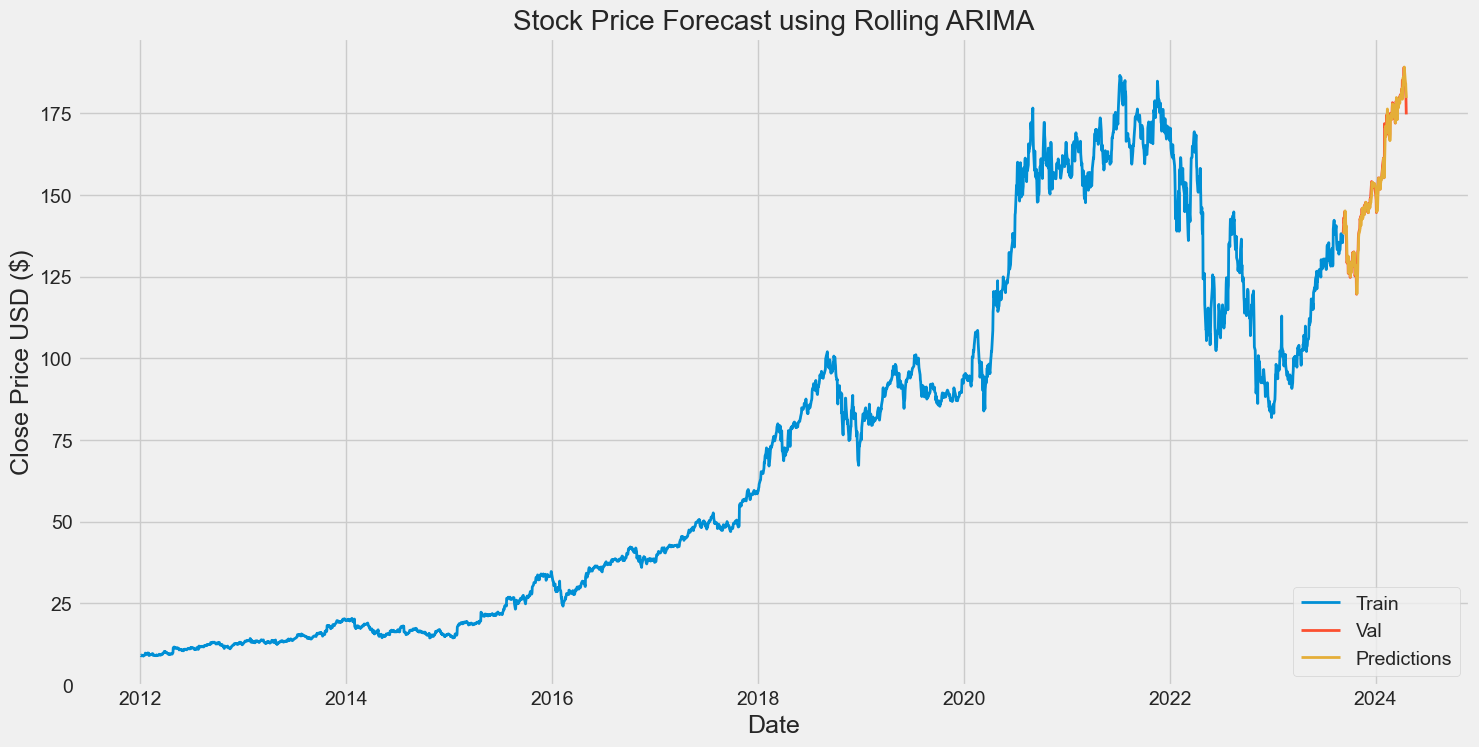

In [32]:
list_of_window_size = [30,60,90]

for i in list_of_window_size:
    rolling_arima_prediction('AMZN',0.95, i)

[*********************100%%**********************]  1 of 1 completed


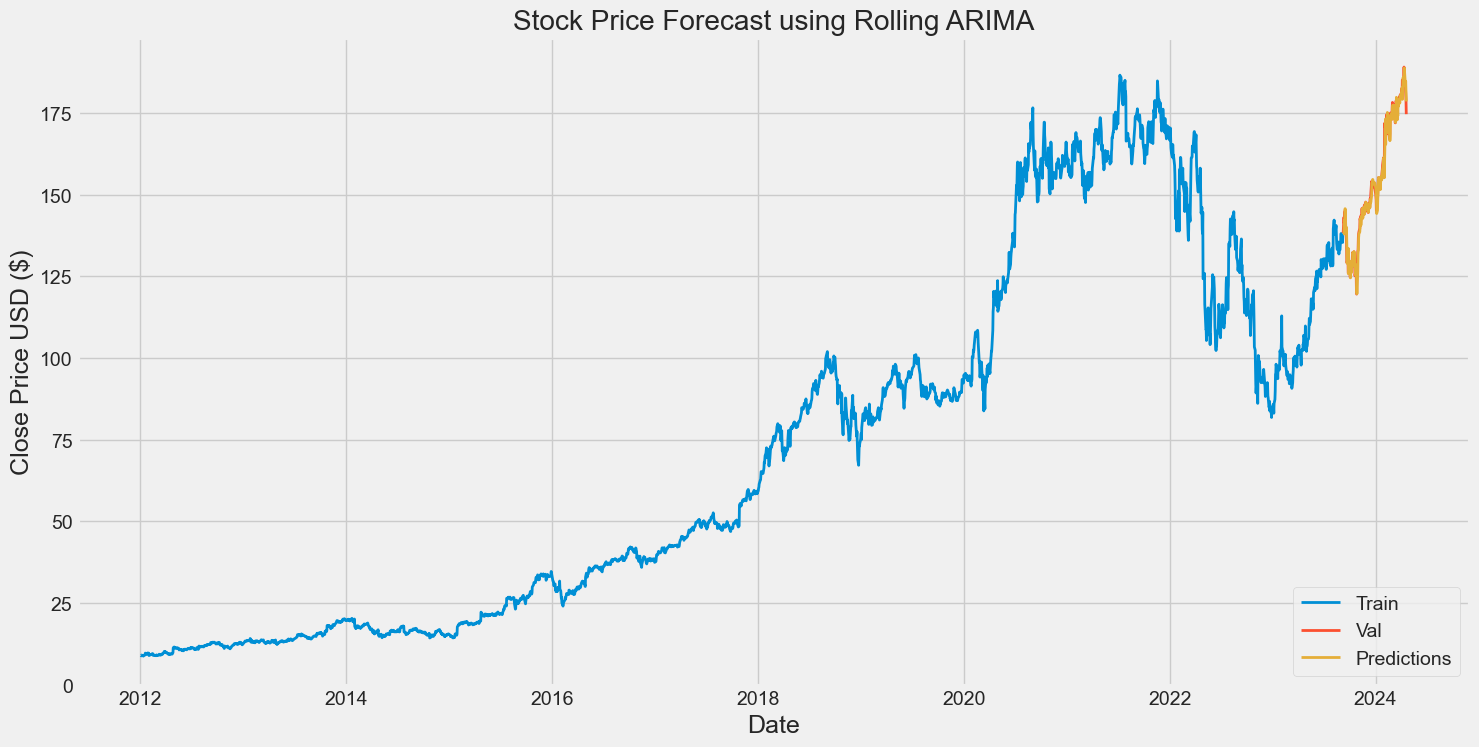

In [28]:
# Get the stock data
df = pdr.get_data_yahoo(ticker, start='2012-01-01', end=datetime.now())

# Use the 'Close' column
data_to_analyze = df['Close'].copy()

# Split dataset into training and testing sets
split_idx = int(len(data_to_analyze) * train_ratio)
train_data = data_to_analyze[:split_idx]
test_data = data_to_analyze[split_idx:]

predictions = []

for end in range(split_idx, len(data_to_analyze)):
    start = max(0, end - window_size)
    rolling_train_data = data_to_analyze[start:end]

    # Optimize ARIMA parameters for the rolling window
    best_p, best_d, best_q, _ = optimize_arima_params(rolling_train_data)

    # Fit ARIMA model
    model = ARIMA(rolling_train_data, order=(best_p, best_d, best_q))
    fitted_model = model.fit()

    # Forecast the next step
    forecast = fitted_model.forecast(steps=1)
    predictions.append(forecast)

# Reverse differencing if applicable
# Reverse differencing if applicable
if best_d == 1:
    first_value = df['Close'].iloc[split_idx]
    # Flatten 'predictions' to a 1D array
    predictions_flattened = np.array(predictions).ravel()

    # Concatenate 'first_value' with the flattened 'predictions_flattened'
    predictions_combined = np.concatenate(([first_value], predictions_flattened))

    # Calculate the cumulative sum to reverse the differencing
    final_predictions = predictions_combined.cumsum()
else:
    final_predictions = np.array(predictions).ravel()  # Flatten if necessary, ensuring it is a 1D array if not already

# Prepare DataFrame for testing data and predictions
test_data_df = df.iloc[split_idx:].copy()
test_data_df['Predictions'] = predictions

# Visualization
plt.figure(figsize=(16,8))
plt.title('Stock Price Forecast using Rolling ARIMA')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df['Close'][:split_idx], label='Train Data', linewidth=2)
plt.plot(test_data_df[['Close', 'Predictions']], label=['Test Data', 'Predictions'], linewidth=2)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Calculate RMSE
rmse = sqrt(mean_squared_error(test_data_df['Close'], test_data_df['Predictions']))

In [31]:
rmse

2.765145896860184

## With method of LSTM

### Data preprocessing

In [48]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2938

In [49]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[8.59898590e-04],
       [4.38268983e-04],
       [4.66008330e-04],
       ...,
       [9.69875715e-01],
       [9.68211460e-01],
       [9.56894018e-01]])

In [50]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.0008599 , 0.00043827, 0.00046601, 0.00185294, 0.00072953,
       0.00094589, 0.00082384, 0.        , 0.00069069, 0.00158943,
       0.0037475 , 0.00513721, 0.00416081, 0.00281825, 0.00307068,
       0.00329259, 0.00482376, 0.00539241, 0.00449922, 0.00513444,
       0.00097917, 0.00160607, 0.0032593 , 0.00199996, 0.00229122,
       0.00264905, 0.00251035, 0.00266569, 0.00434388, 0.00426344,
       0.00236889, 0.00110955, 0.00182243, 0.00175586, 0.00128985,
       0.00082106, 0.00088764, 0.00072121, 0.00218303, 0.00104297,
       0.00114006, 0.00093479, 0.00120108, 0.00143131, 0.00217472,
       0.0032482 , 0.00232727, 0.00206931, 0.00240217, 0.00175586,
       0.00235779, 0.00252977, 0.00266014, 0.00454915, 0.00438272,
       0.00456856, 0.00530087, 0.00747281, 0.00818569, 0.00699847])]
[0.007955462682385742]

[array([0.0008599 , 0.00043827, 0.00046601, 0.00185294, 0.00072953,
       0.00094589, 0.00082384, 0.        , 0.00069069, 0.00158943,
       0.0037475 , 0.00513721, 0.0

### Model training

In [51]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2878/2878 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - loss: 0.0021


### Visualization and evaluation of fitting effects

In [52]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


5.256397568558897

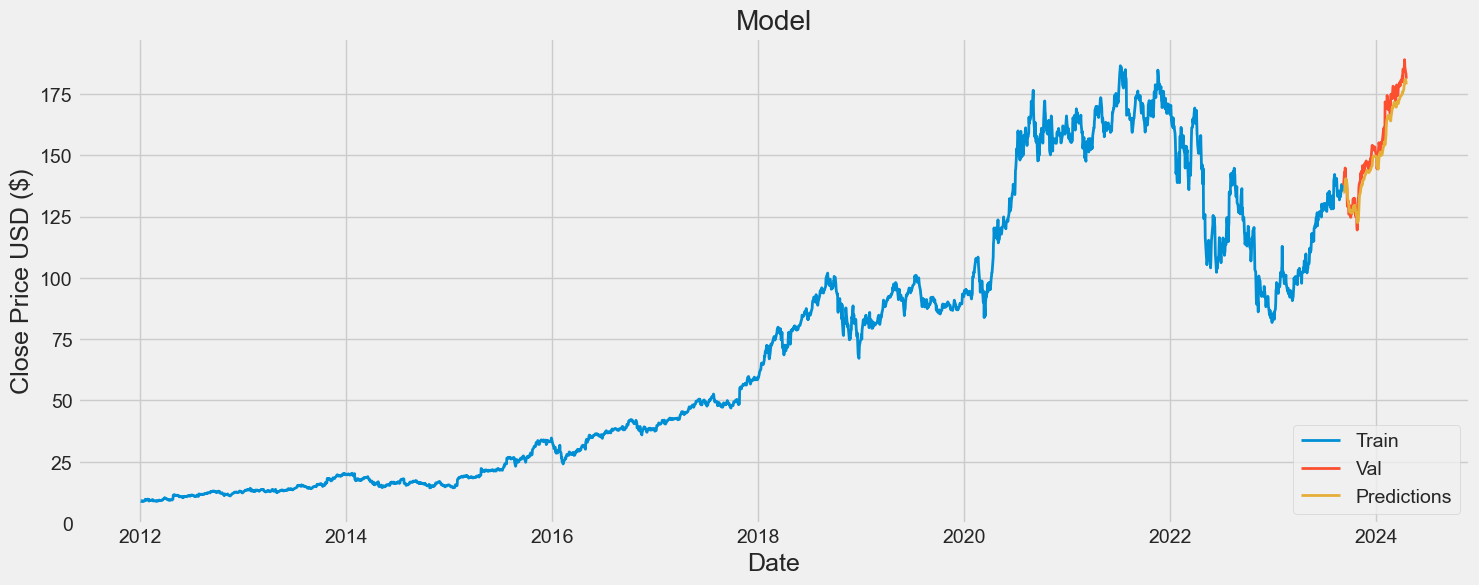

In [53]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'], linewidth=2)
plt.plot(valid[['Close', 'Predictions']], linewidth=2)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [54]:
# Show the valid and predicted prices
valid

Close  Predictions
Date                               
2023-09-07  137.850006   134.875412
2023-09-08  138.229996   134.868713
2023-09-11  143.100006   135.126404
2023-09-12  141.229996   136.728836
2023-09-13  144.850006   137.787155
...                ...          ...
2024-04-11  189.050003   179.650406
2024-04-12  186.130005   180.843018
2024-04-15  183.619995   180.968277
2024-04-16  183.320007   180.021774
2024-04-17  181.279999   178.977203

[154 rows x 2 columns]

## Predicting the closing price stock price of selected stocks with LSTM

In [77]:
def price_pred_plot_LSTM(ticker):
    df = pdr.get_data_yahoo(ticker, start='2012-01-01', end=datetime.now())
    data = df.filter(['Close'])
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .95 ))
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=1, epochs=1)
    
    test_data = scaled_data[training_data_len - 60: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    
    y_test_range = np.max(y_test) - np.min(y_test)
    nrmse = rmse / y_test_range
    
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    plt.figure(figsize=(16,6))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Close'], linewidth=2)
    plt.plot(valid[['Close', 'Predictions']], linewidth=2)
    plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
    plt.show()
    
    return rmse, nrmse, valid

[*********************100%%**********************]  1 of 1 completed


2877/2877 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0052
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


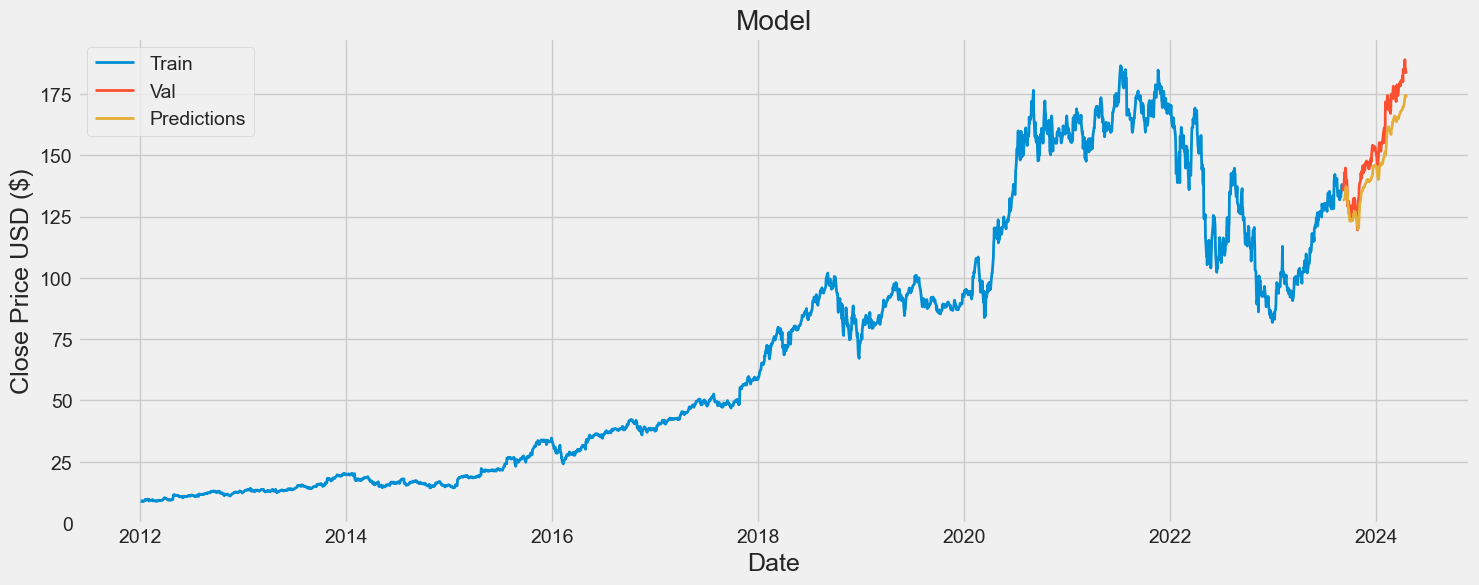

In [101]:
AMZN_rmse, AMZN_nrmse, AMZN_pred = price_pred_plot_LSTM('AMZN')

In [102]:
AMZN_rmse, AMZN_nrmse

(9.167876764509332, 0.1319498607018194)

[*********************100%%**********************]  1 of 1 completed


2229/2229 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.0028
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


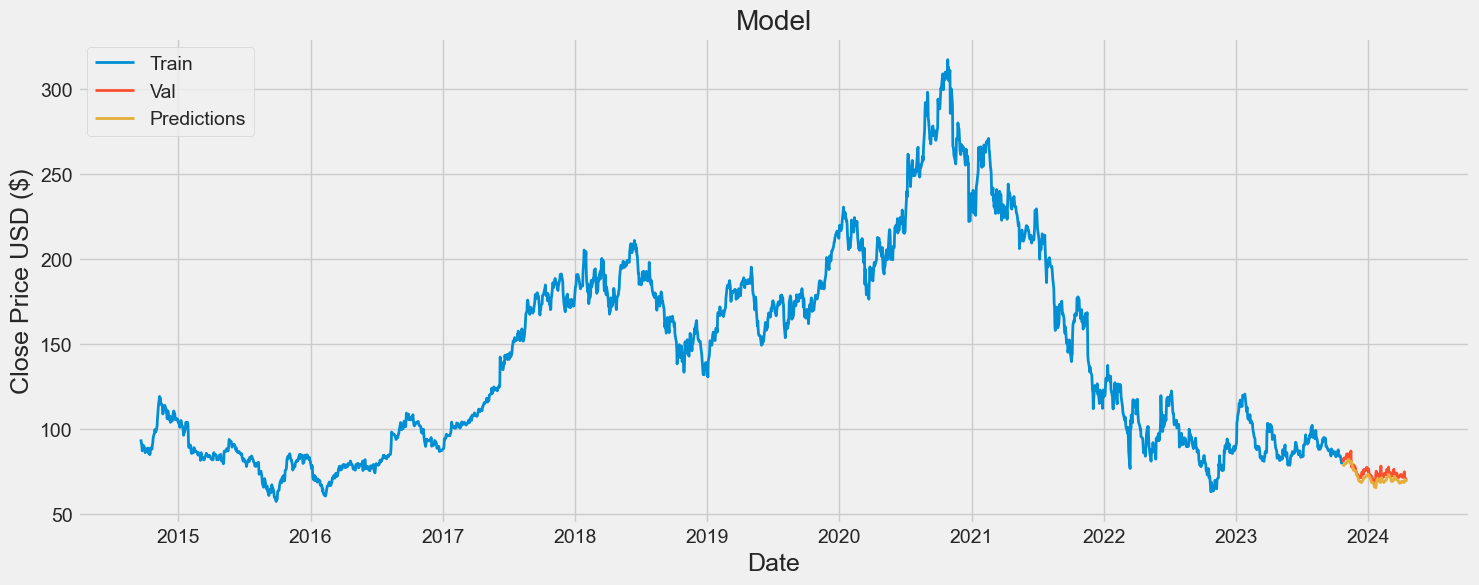

In [103]:
BABA_rmse, BABA_nrmse, BABA_pred = price_pred_plot_LSTM('BABA')

In [104]:
BABA_rmse, BABA_nrmse

(3.6519446115113308, 0.19200553396746362)

[*********************100%%**********************]  1 of 1 completed


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0049
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


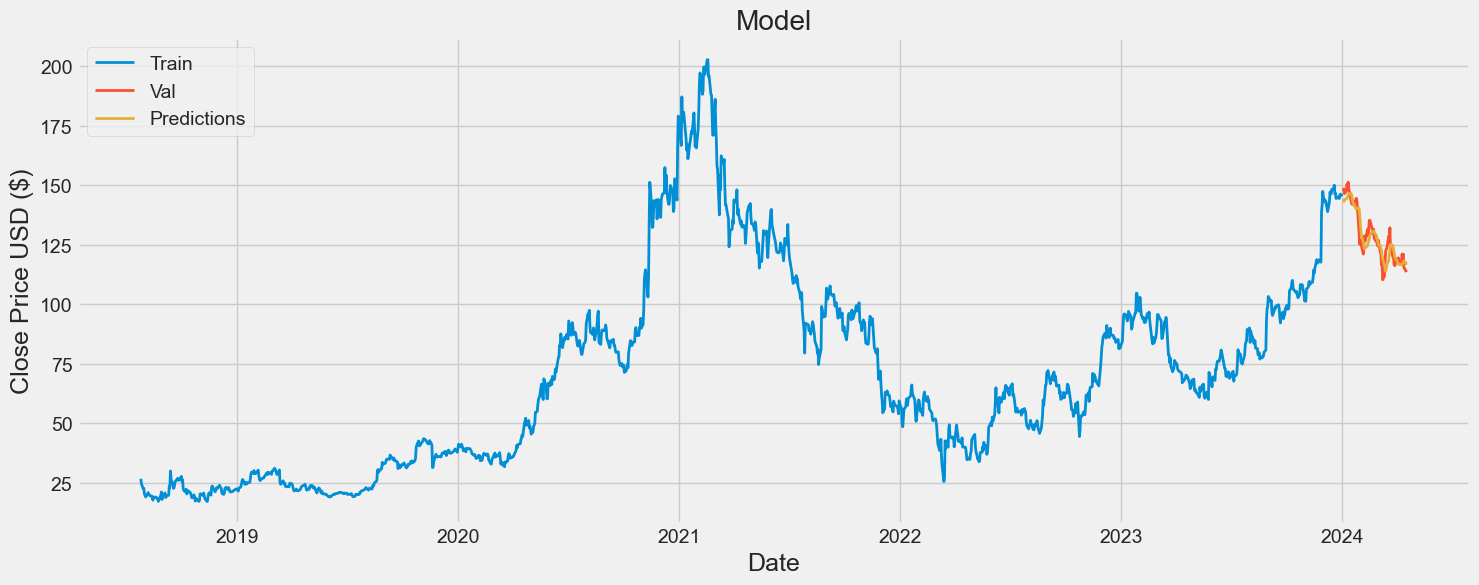

In [105]:
PDD_rmse, PDD_nrmse, PDD_pred = price_pred_plot_LSTM('PDD')

In [106]:
PDD_rmse, PDD_nrmse

(4.776710389128347, 0.11653353864333985)

[*********************100%%**********************]  1 of 1 completed


1004/1004 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0062
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


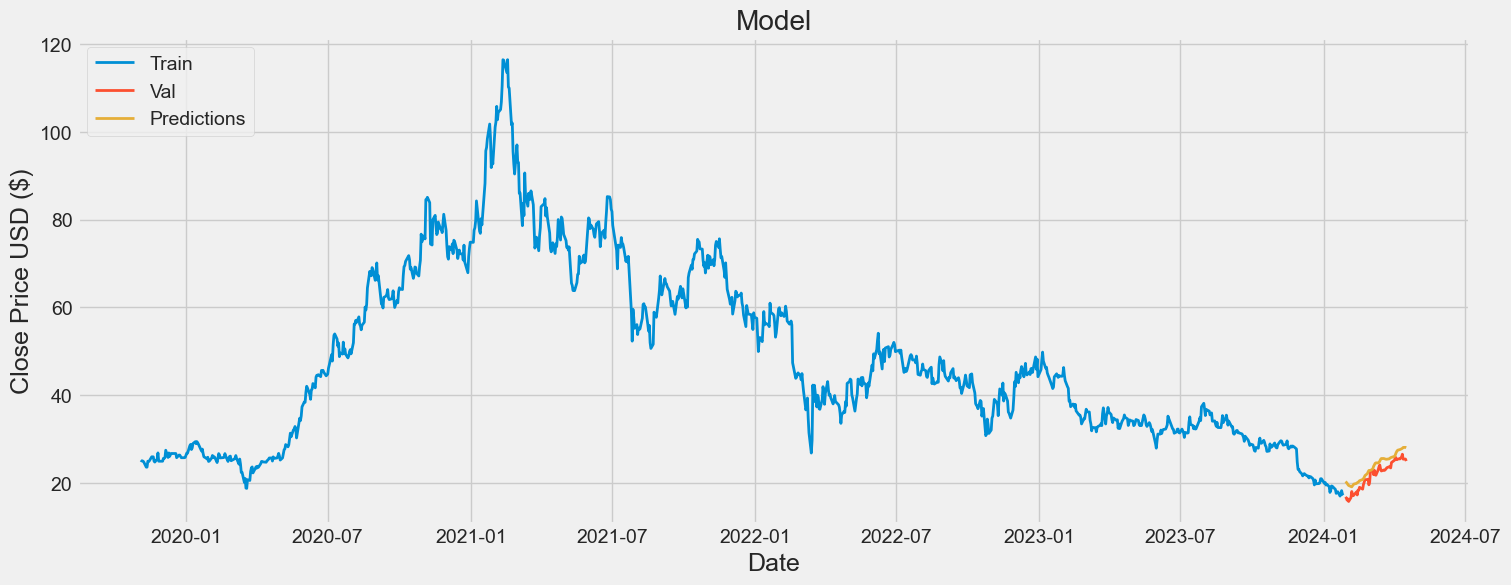

In [107]:
MPNGY_rmse, MPNGY_nrmse, MPNGY_pred = price_pred_plot_LSTM('MPNGY')

In [108]:
MPNGY_rmse, MPNGY_nrmse

(2.2008140398372436, 0.20453661645190774)

[*********************100%%**********************]  1 of 1 completed


2877/2877 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.0023
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


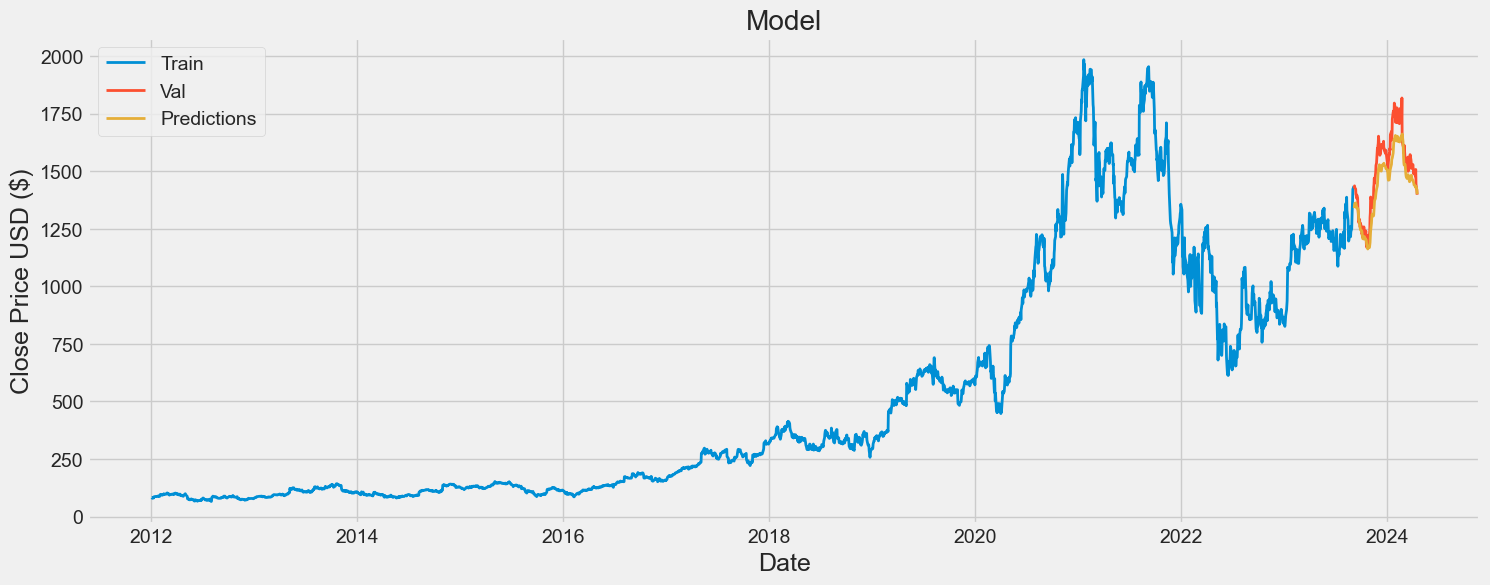

In [109]:
MELI_rmse, MELI_nrmse, MELI_pred = price_pred_plot_LSTM('MELI')

In [111]:
MELI_rmse, MELI_nrmse

(81.73929813181478, 0.1260805881985117)

[*********************100%%**********************]  1 of 1 completed


2880/2880 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - loss: 0.0022
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000166FCBAC400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


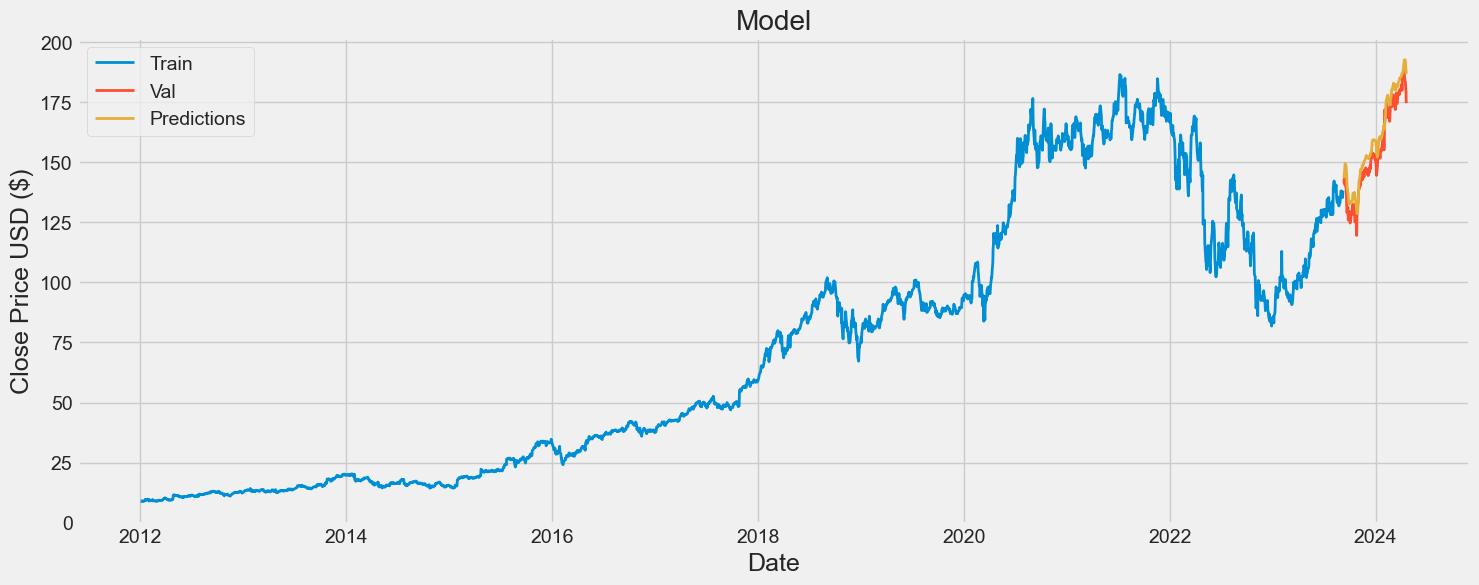

In [81]:
rmse, nrmse, valid = price_pred_plot_LSTM('AMZN')

In [86]:
valid['Predictions'].values.tolist()

[143.3899688720703,
 145.245361328125,
 146.4020538330078,
 148.1666717529297,
 149.48593139648438,
 148.8279266357422,
 147.59999084472656,
 145.77345275878906,
 143.58807373046875,
 140.1070556640625,
 137.2968292236328,
 136.29193115234375,
 134.59657287597656,
 133.31675720214844,
 132.60430908203125,
 132.69454956054688,
 133.78250122070312,
 133.37954711914062,
 133.3369140625,
 133.03123474121094,
 133.33355712890625,
 133.79336547851562,
 134.52621459960938,
 135.834716796875,
 137.05184936523438,
 137.02725219726562,
 137.45013427734375,
 137.4818115234375,
 136.30616760253906,
 135.18179321289062,
 133.3839874267578,
 132.38580322265625,
 132.59898376464844,
 130.93743896484375,
 128.6793670654297,
 129.46026611328125,
 132.5710906982422,
 135.68826293945312,
 139.1265411376953,
 141.89175415039062,
 143.67282104492188,
 144.84573364257812,
 146.3131561279297,
 147.12713623046875,
 146.9620361328125,
 147.46469116210938,
 147.67755126953125,
 148.80123901367188,
 149.02597045

## Rolling ARIMA vs LSTM

In [173]:
def compare_models(ticker, window_size):
    # Get stock data just once, assuming both prediction functions need it
    df = pdr.get_data_yahoo(ticker, start='2012-01-01', end=datetime.now())
    
    # Run the rolling ARIMA prediction
    rmse_arima, nrmse_arima, valid_arima = rolling_arima_prediction(ticker, 0.95, window_size)
    
    # Run the LSTM prediction
    rmse_lstm, nrmse_lstm, valid_lstm = price_pred_plot_LSTM(ticker)
    
    valid_lstm['Predictions'].values.tolist()
    
    # Plot both sets of predictions along with the true values
    plt.figure(figsize=(16,8))
    plt.title(f'Stock Price Prediction Comparison for {ticker}')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    
    # Plot training data
    plt.plot(df['Close'][:int(len(df) * train_ratio)], label='Train Data', linewidth=2)
    
    # Plot ARIMA predictions
    plt.plot(valid_arima.index, valid_arima['Close'], label='Test Data (ARIMA)', alpha=0.5)
    plt.plot(valid_arima.index, valid_arima['Prediction'], label='ARIMA Predictions', linewidth=2)
    
    # Plot LSTM predictions
    plt.plot(valid_lstm.index, valid_lstm['Close'], label='Test Data (LSTM)', alpha=0.5)
    plt.plot(valid_lstm.index, valid_lstm['Predictions'], label='LSTM Predictions', linewidth=2)
    
    plt.legend(loc='upper left')
    plt.show()
    
    return rmse_arima, nrmse_arima, valid_arima, rmse_lstm, nrmse_lstm, valid_lstm

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


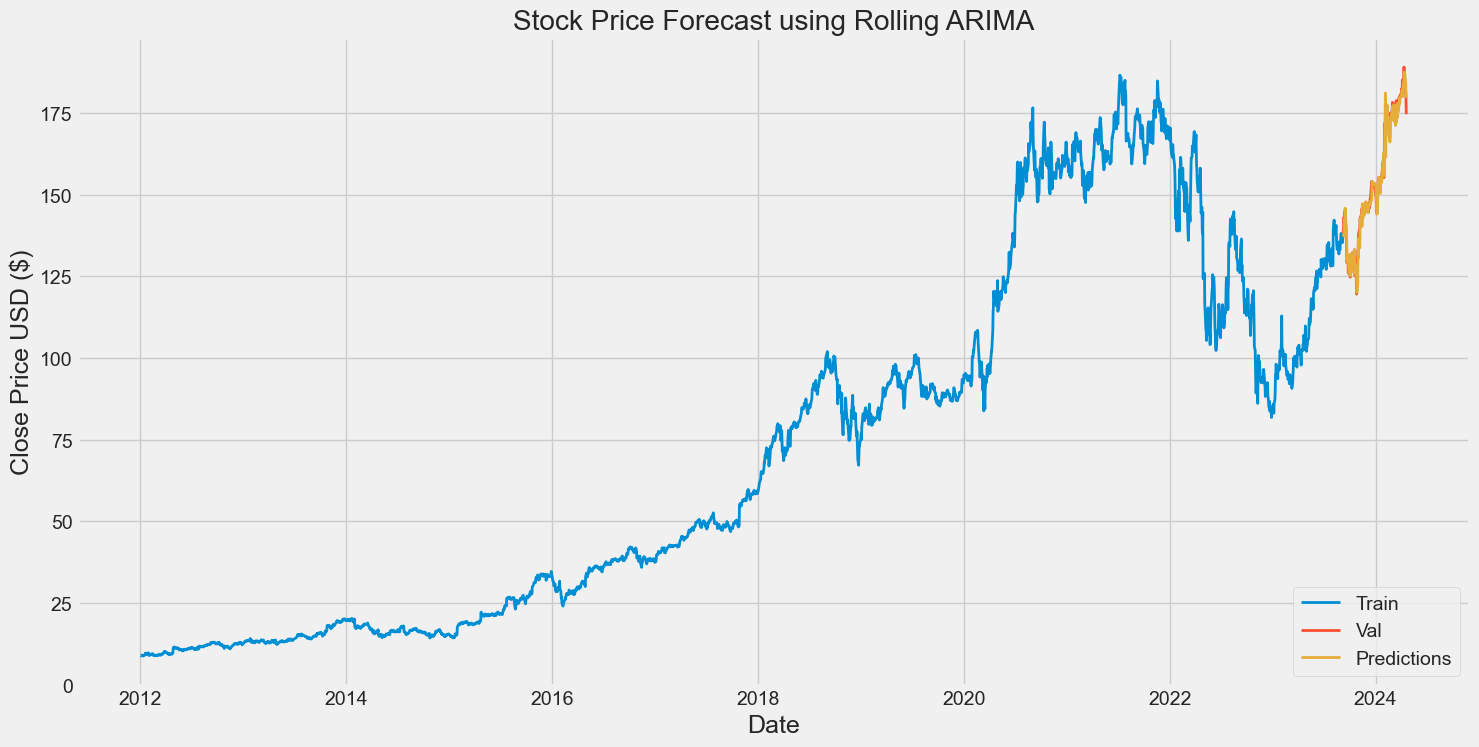

[*********************100%%**********************]  1 of 1 completed


2880/2880 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.0058
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


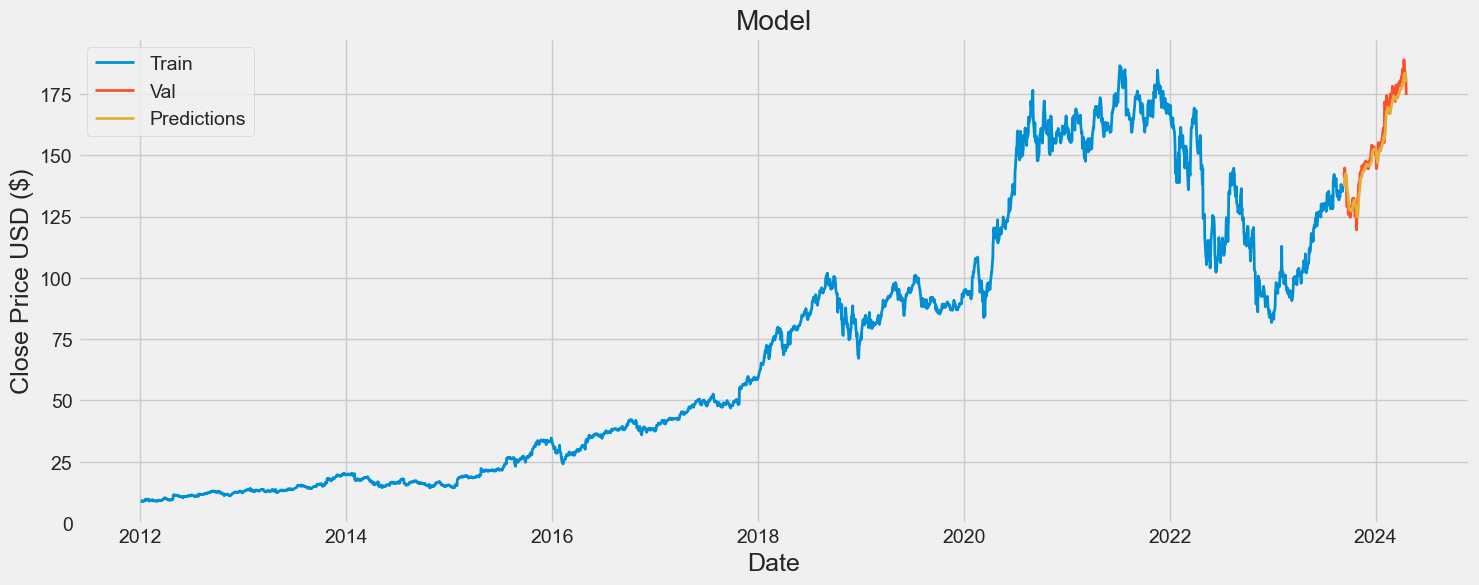

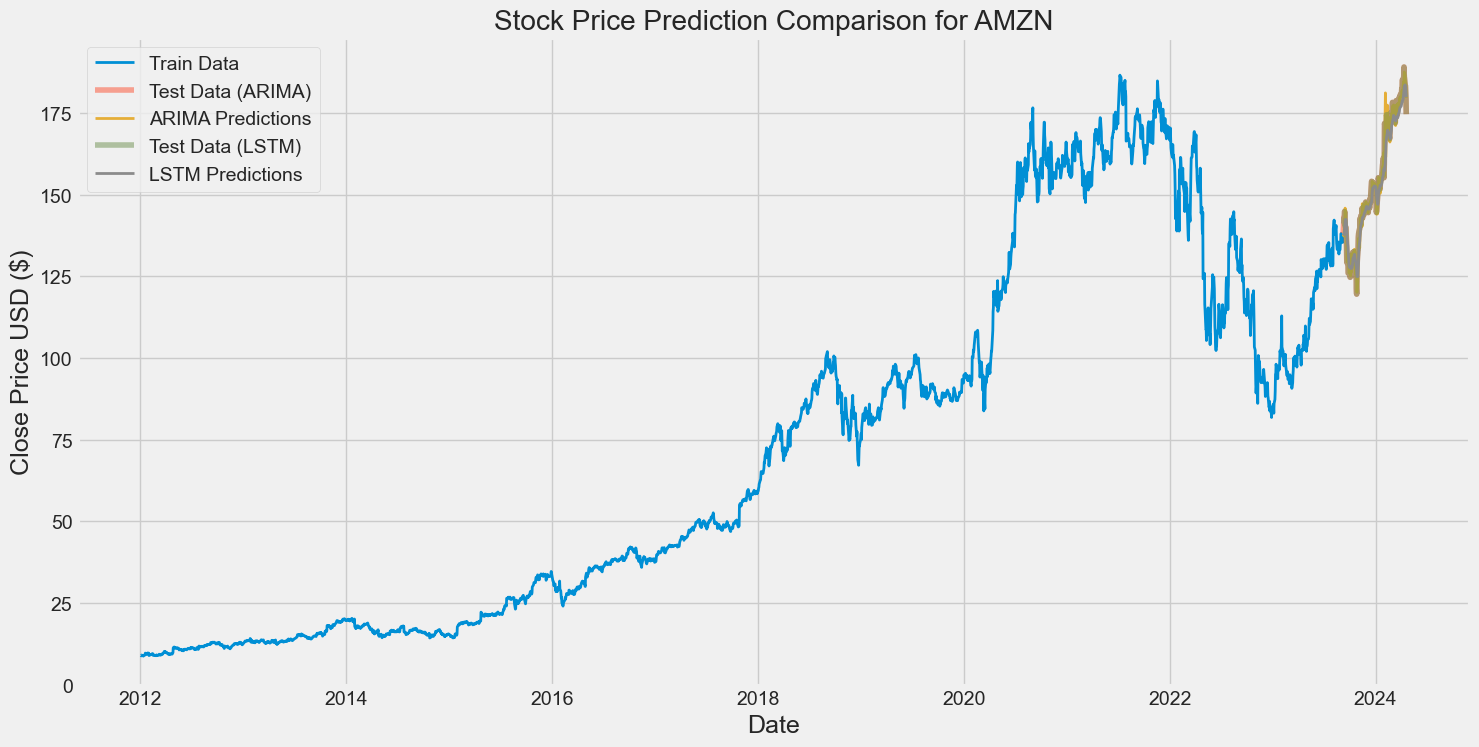

In [174]:
rmse_arima, nrmse_arima, valid_arima, rmse_lstm, nrmse_lstm, valid_lstm = compare_models('AMZN', 30)

In [184]:
valid_arima

Close  Prediction
Date                              
2023-09-08  138.229996  137.805966
2023-09-11  143.100006  137.336797
2023-09-12  141.229996  142.345787
2023-09-13  144.850006  140.538190
2023-09-14  144.720001  141.918696
...                ...         ...
2024-04-15  183.619995  186.453303
2024-04-16  183.320007  184.627883
2024-04-17  181.279999  183.951247
2024-04-18  179.220001  181.973435
2024-04-19  174.630005  179.623152

[155 rows x 2 columns]

In [185]:
valid_lstm

Close  Predictions
Date                               
2023-09-11  143.100006   137.413895
2023-09-12  141.229996   138.680206
2023-09-13  144.850006   139.678009
2023-09-14  144.720001   141.106049
2023-09-15  140.389999   142.358307
...                ...          ...
2024-04-15  183.619995   183.597076
2024-04-16  183.320007   183.144394
2024-04-17  181.279999   182.404572
2024-04-18  179.220001   181.285614
2024-04-19  174.630005   179.862106

[154 rows x 2 columns]

In [186]:
# 假设 df1 和 df2 是您要合并的两个DataFrame
merged_valid = valid_lstm.merge(valid_arima, left_index=True, right_index=True, how='inner')
# Assuming 'merged_valid' is your merged DataFrame
# You can drop the 'Close_y' column if it's redundant
merged_valid.drop(columns=['Close_y'], inplace=True)

# Rename 'Close_x' to just 'Close'
merged_valid.rename(columns={'Close_x': 'Close'}, inplace=True)

# If you also want to rename 'Predictions' to match 'Prediction', you can do so like this:
# 重命名列 'Predictions' 为 'LSTM' 和 'Prediction' 为 'ARIMA'
merged_valid.rename(columns={'Predictions': 'LSTM', 'Prediction': 'ARIMA'}, inplace=True)
# 现在 'merged_valid' DataFrame 应该有一个 'Close' 列，和两个预测列 'LSTM' 和 'ARIMA'


In [187]:
merged_valid

Close        LSTM       ARIMA
Date                                          
2023-09-11  143.100006  137.413895  137.336797
2023-09-12  141.229996  138.680206  142.345787
2023-09-13  144.850006  139.678009  140.538190
2023-09-14  144.720001  141.106049  141.918696
2023-09-15  140.389999  142.358307  145.875640
...                ...         ...         ...
2024-04-15  183.619995  183.597076  186.453303
2024-04-16  183.320007  183.144394  184.627883
2024-04-17  181.279999  182.404572  183.951247
2024-04-18  179.220001  181.285614  181.973435
2024-04-19  174.630005  179.862106  179.623152

[154 rows x 3 columns]

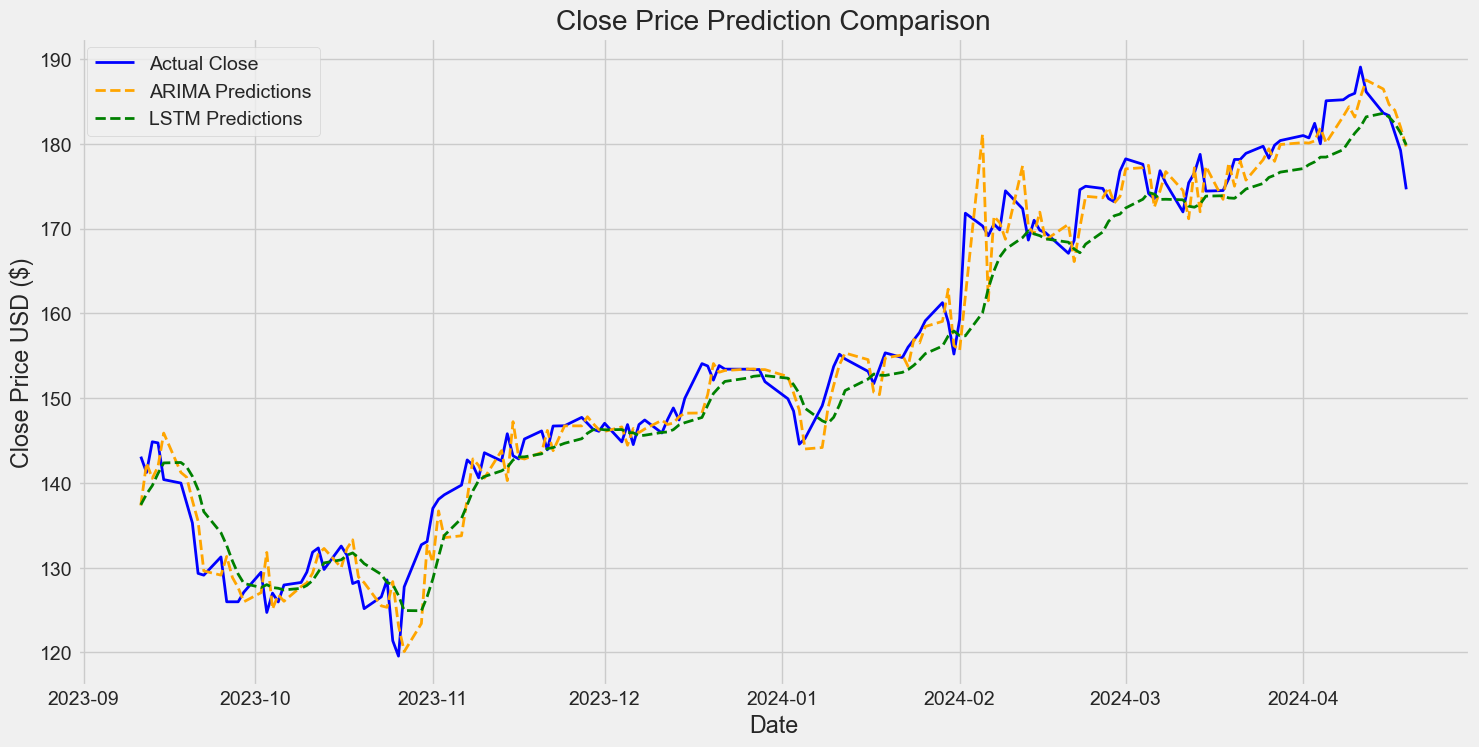

In [188]:

# Now, plotting the results
plt.figure(figsize=(16,8))
plt.title('Close Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')

# Plot the actual close prices
plt.plot(merged_valid.index, merged_valid['Close'], label='Actual Close', color='blue', linewidth=2)

# Plot the ARIMA predictions
plt.plot(merged_valid.index, merged_valid['ARIMA'], label='ARIMA Predictions', color='orange', linestyle='--', linewidth=2)

# Plot the LSTM predictions
plt.plot(merged_valid.index, merged_valid['LSTM'], label='LSTM Predictions', color='green', linestyle='--', linewidth=2)

plt.legend()
plt.show()


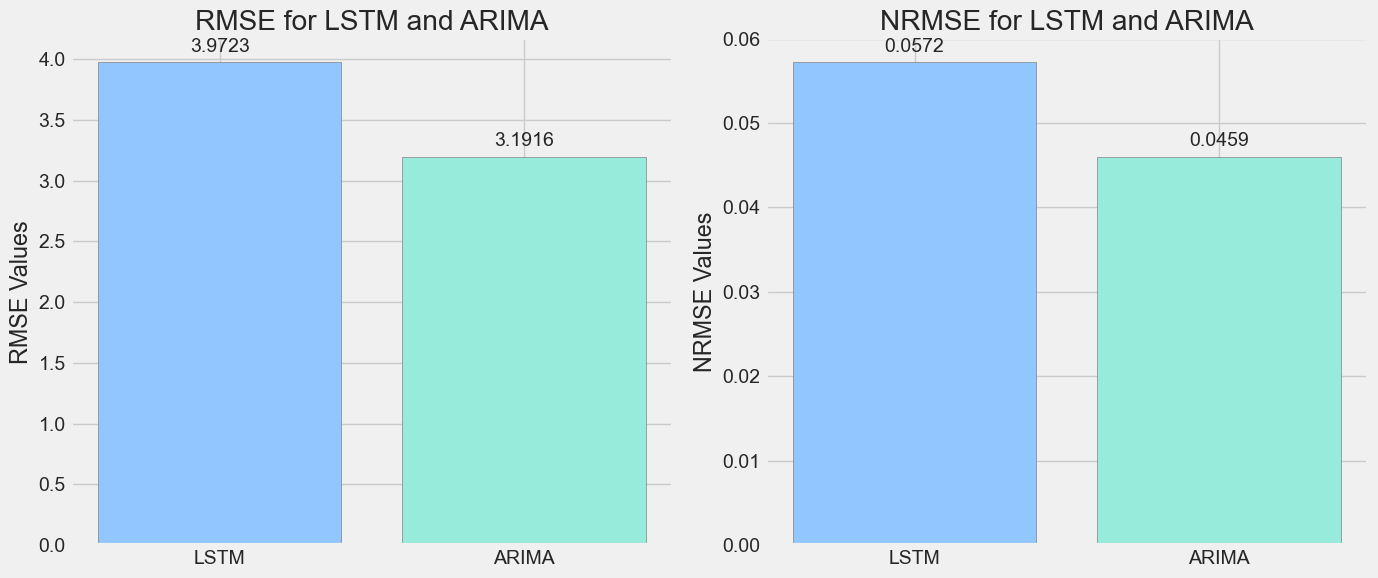

In [199]:
LSTM_dic = {
    'RMSE':rmse_lstm,
    'NRMSE':nrmse_lstm
}

ARIMA_dic = {
    'RMSE':rmse_arima,
    'NRMSE':nrmse_arima
}


# Extract the metrics for plotting
models = ['LSTM', 'ARIMA']
rmse_values = [LSTM_dic['RMSE'], ARIMA_dic['RMSE']]
nrmse_values = [LSTM_dic['NRMSE'], ARIMA_dic['NRMSE']]

# Set the positions for the bars
positions = np.arange(len(models))

# Create the figure and the axes for subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Define a function to add labels above the bars
def add_value_labels(ax, spacing=5):
    for i in ax.patches:
        y_value = i.get_height()
        x_value = i.get_x() + i.get_width() / 2
        label = "{:.4f}".format(y_value)
        ax.annotate(label, (x_value, y_value), xytext=(0, spacing),
                    textcoords="offset points", ha='center', va='bottom')

# Choose soft colors
colors = ['#92c6ff', '#97ebdb']

# Plot RMSE bars
rmse_bars = ax[0].bar(positions, rmse_values, color=colors, edgecolor='gray')
ax[0].set_title('RMSE for LSTM and ARIMA')
ax[0].set_xticks(positions)
ax[0].set_xticklabels(models)
add_value_labels(ax[0])  # Call the function to add labels

# Plot NRMSE bars
nrmse_bars = ax[1].bar(positions, nrmse_values, color=colors, edgecolor='gray')
ax[1].set_title('NRMSE for LSTM and ARIMA')
ax[1].set_xticks(positions)
ax[1].set_xticklabels(models)
add_value_labels(ax[1])  # Call the function to add labels

# Adding labels and title to the plots
ax[0].set_ylabel('RMSE Values')
ax[1].set_ylabel('NRMSE Values')

# Show the plot
plt.tight_layout()
plt.show()